(air:sequence)=
# Clonotype analysis

```{dropdown} <i class="fas fa-brain"></i>&nbsp;&nbsp;&nbsp;Key takeaways

:::{card}
:link: air-repertoire-clonotype-key-takeaway-1
:link-type: ref
Clonal Expansion: Specific lymphocytes proliferate in response to immune stimuli, reducing clonal diversity but increasing the abundance of expanded clones.
This process is critical for understanding immune responses, as it reflects the transition from naive to effector and memory cells.
:::

:::{card}
:link: air-repertoire-clonotype-key-takeaway-2
:link-type: ref
Gene Segment Usage & Spectratype: The rearrangement of V(D)J gene segments shows preferential usage, and spectratype analysis measures CDR3 length diversity.
Together, they help identify immunodominant clonotypes and characterize immune repertoire patterns.
:::

```

<!-- START ENV-SETUP -->
<!-- END ENV-SETUP -->

(air-repertoire-clonotype-key-takeaway-1)=
## Clonal expansion: diversity and abundance

In general, lymphocytes are in a dormant state until receiving an external signal (epitope recognition of foreign agent) or stimulation from autocrine agents (signaling from the same organism as a response from the innate immune system). As a consequence, the specific cells proliferate dramatically to fulfill the defense response they are programmed to perform in a process known as clonal expansion {cite}`polonsky2016clonal`. This refers to the recognition of the proliferation of specific cells given the high number of the same IR through many, different cells (expanded clones). This expansion provides hints of differentiation from naive lymphocytes to mature effector and memory lymphocytes, helping in the interpretation and expected results regarding previous cell annotation {cite}`polonsky2016clonal`. On the other hand, the analysis of expanded clones should consider derivative processes such as clonal competitions (two or more clones in expansion competing for the same space), clonal dominance (one single clonal expanded cell outnumbering the rest of the clonal cells), and bystander activation (activation of T-cells by cytokines but not for T-cell receptor coupling) {cite}`naxerova2020clonal`{cite}`ashcroft2017clonal`{cite}`kim2019activation`.

The dynamical changes in terms of the number of cells per clonotype in a given space allow applying concepts from population biology such as diversity and abundance. Diversity is defined as number of species and their amount in an area or community, whereas abundance is the number, or frequency of individuals of the same species {cite}`travlos2018weed`. Here, we can replace the term species with clones to make clear their relevance in single-cell IRs analysis. If a high clonal expansion has been detected in a specific cell type, e.g., effector CD8+ T-cells, the number of clones is expected to reduce because the expanded clones are taken space from the total available sacrificing receptor alternatives in the process. Therefore, we could expect a reduction in the diversity for this cell-type. On the other hand, we could expect an increase in abundance regarding the expanded clones given they have increased the number of individuals (cells) belonging to this specific clone (observed by the number of cells per clone ID).

(air-repertoire-clonotype-key-takeaway-2)=
## Gene segment usage and spectratype

The process shaping a T-cell or B-cell receptor by rearrangement of the V(D)J segments is thinking to generate random sequences and, in consequence, the distribution of V(D)J sequences should follow a uniform distribution. Nevertheless, it has been observed that V(D)J gene usage frequency is largely consistent across different individuals, which suggests a preference selection in terms of the V(D)J gene segments used {cite}`elhanati2014quantifying`. That allows the analysis of gene segment usage in terms of abundance of most used gene segments per cell type and frequency of most abundant segment per cell type per individual {cite}`chernyshev2021vdj`. Likewise, considering we know the amino aicd composition of the immune receptors for each cell, it is possible to identify the exact combinations of V(D)J segments of interest.

On the other hand, the recombination of V(D)J gene segments and the imprecise junction of V and J segments produce CDR3 regions with variable lengths. Spectratype analysis is seen as the measurement of the heterogeneity of CDR3 regions by their length diversity across the different cell types {cite}`ciupe2013quantification`. This measurement, in combination with clonal expansion and gene segment usage provides pieces of evidence to define well-described immunodominant clonotypes.

## TCR data preparation

Here, as well as in the pre-processing step, we will use the utilities from the *Scirpy* library to perform the analysis and locate the results in the *AnnData* object.

:::{warning}
Scirpy changed the format of [its datastructure](https://scirpy.scverse.org/en/latest/data-structure.html#storing-airr-rearrangement-data-in-anndata)
with v0.13. While the overall analysis workflow has not changed, some outputs shown in this chapter might not be accurate anymore. 

See [the scirpy release notes](https://scirpy.scverse.org/en/latest/changelog.html#v0-13-0-new-data-structure-based-on-awkward-arrays) for more details about this change. 
Until we update this chapter, please also refer to the [official scirpy documentation](https://scirpy.scverse.org).
:::

In [53]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import scanpy as sc
import scirpy as ir
from palmotif import compute_motif, svg_logo

warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

In [2]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.6.1
sinfo       0.3.1
-----
Levenshtein                 NA
PIL                         8.1.0
adjustText                  NA
airr                        1.3.1
anndata                     0.8.0
anyio                       NA
attr                        20.3.0
babel                       2.9.0
backcall                    0.2.0
brotli                      1.0.9
certifi                     2020.12.05
cffi                        1.14.4
chardet                     4.0.0
cloudpickle                 1.6.0
constants                   NA
cycler                      0.10.0
cython_runtime              NA
dask                        2020.12.0
dateutil                    2.8.1
decorator                   4.4.2
future_fstrings             NA
get_version                 2.1
google                      NA
h5py                        3.7.0
highs_wrapper               NA
idna                        2.10
igraph                      0.8.3
ipykernel                   5.4

In [3]:
path_data = "/home/icb/juan.henao/BestPracticeStart/data"

path_gex = f"{path_data}/TCR_filtered.h5ad"
adata = sc.read(path_gex)

**Note**

Before performing any analysis, it is necessary to reduce the size of our data to make this tutorial computationally less expensive and make it timely suitable.

To do so, we have chosen six samples ensuring the different centers and medical statuses were represented.

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


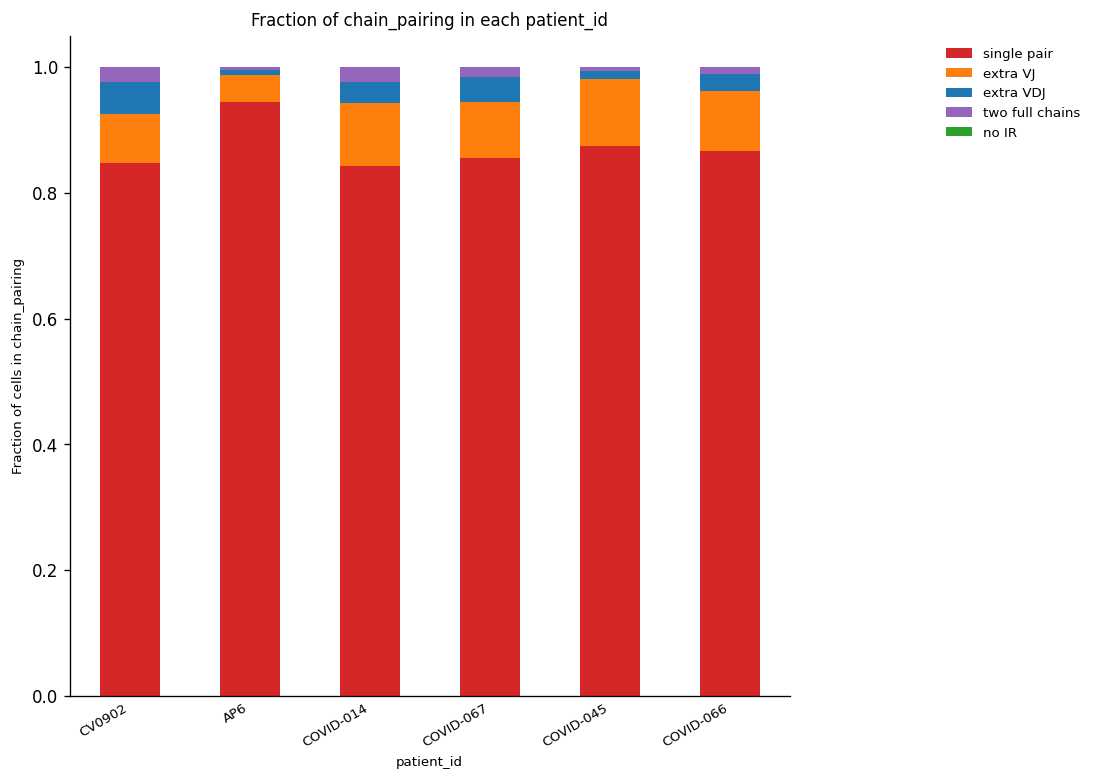

In [4]:
adata = adata[
    adata.obs["patient_id"].isin(
        ["COVID-014", "CV0902", "AP6", "COVID-045", "COVID-066", "COVID-067"]
    )
]
# adata[adata.obs['Status'] == 'Healthy'].obs['patient_id']
_ = ir.pl.group_abundance(
    adata,
    groupby="patient_id",
    target_col="chain_pairing",
    normalize=True,
    figsize=[10, 10],
)

## Clonotype definition

One way to define the clonotypes is by detecting all identical sequences for VJ CDR3 and VDJ CDR3. It is the most used one due to allowing to define trustable cell lineages. However, another way to deal with this problem is finding a distance between sequences, this method is restrictive, and it could be useful to test some hypotheses regarding complex immunological phenotypes. 

In [5]:
ir.pp.ir_dist(adata, sequence="aa")

Once the identity between T-cells is obtained for V(D)J CDR3, it is time to define the cluster of cells corresponding to one specific clonotype. A clonotype will be a set of cells with identical sequences, considering the parameters used in the previous step. However, it is possible to define clonotypes as a set of cells with just identical VJ or just identical VDJ sequences. Furthermore, it is possible defining the clonotypes by comparing either or both pairs of VJ or VDJ sequences.

The set of parameters to define clonotypes should be the same as used previously. In our case, the sequences of amino acids must be compared using identity as a metric. In addition, we are setting the additional parameters to define clonotypes if the V(D)J are identical using the most abundant pair as the target sequence.

In [6]:
ir.tl.define_clonotype_clusters(
    adata, sequence="aa", receptor_arms="all", dual_ir="primary_only"
)

  0%|          | 0/14181 [00:00<?, ?it/s]

The way to visualize the results is through a network where each node represents a clonotype (cluster of cells), and its size represents the number of cells detected in that cluster. They are labeled with a numerical ID, however, the order is given randomly, and it is not showing any additional information beyond to identify clonotypes of interest.

To generate the network, it is necessary to establish the layout to be plotted afterward. This parameter should be one of the igraph library layouts. Furthermore, it is recommended to set at least *min_cells* >=2 to avoid overcrowding the plot with singletons (clonotypes with only one cell as a member). Here, this parameter is established as >= 50 to show just the biggest clonotypes to easier the observation of the expected result.

In [7]:
ir.tl.clonotype_network(adata, min_cells=50, sequence="aa")

Now it is possible to plot the network. The result is just like the one you can observe below. As we said previously, each node (circle) represents a clonotype with a unique number as ID. Furthermore, the size represents the number of cells belonging to each specific clonotype.

On the other hand, we set the color according to the samples to observe if a clonotype appears in two or more samples, those clonotypes are called *public clonotypes* and are of high interest due to they represent shared immunological responses, and therefore they are candidates to explain general response over the disease/phenotype under study. Otherwise, there are *privet clonotypes* which represent patient/sample specific clonal response, and it could be interesting for analysis regarding personalized medicine. As you can see below, the highest clonotypes are composed just of private clonotypes.

... storing 'cc_aa_identity' as categorical


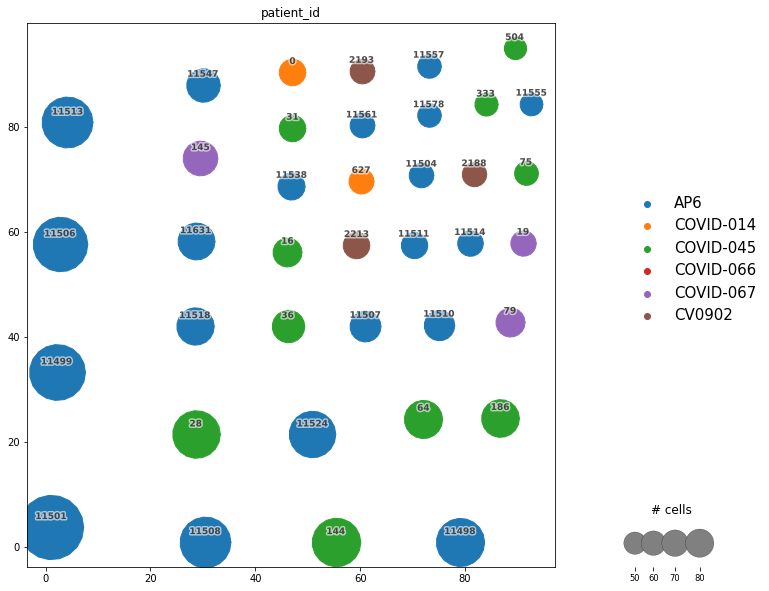

In [8]:
_ = ir.pl.clonotype_network(
    adata,
    color="patient_id",
    base_size=10,
    label_fontsize=9,
    panel_size=(10, 10),
    legend_fontsize=15,
)

In [9]:
adata.obs["cc_aa_identity"] = adata.obs["cc_aa_identity"].astype("str")

As mentioned previously, the detected clonotypes are labeled with a number we can use to extract more information. For instance, we are extracting the immune sequences for clonotype number 0.

In [10]:
adata.obs.loc[adata.obs["cc_aa_identity"] == "0", :].groupby(
    [
        "IR_VJ_1_junction_aa",
        "IR_VDJ_1_junction_aa",
        "receptor_subtype",
    ],
    observed=True,
).size().reset_index(name="n_cells")

,IR_VJ_1_junction_aa,IR_VDJ_1_junction_aa,receptor_subtype,n_cells
0,CAVSVVRNNNARLMF,CASSARGASGERTDTQYF,TRA+TRB,71


## Clonal expansion

The positive selection of immune cells, e.g., for immune response activation, causes their expansion (division) reflected in the representation of clonotypes in one or more cells. The first step is to identify the clonal expansion and add a column in the .obs table. 

Once the clonal expansion has been identified, it is easy to observe that, plotting the number of cells per cell type corresponding to expanded clones as a stacked bar plot.

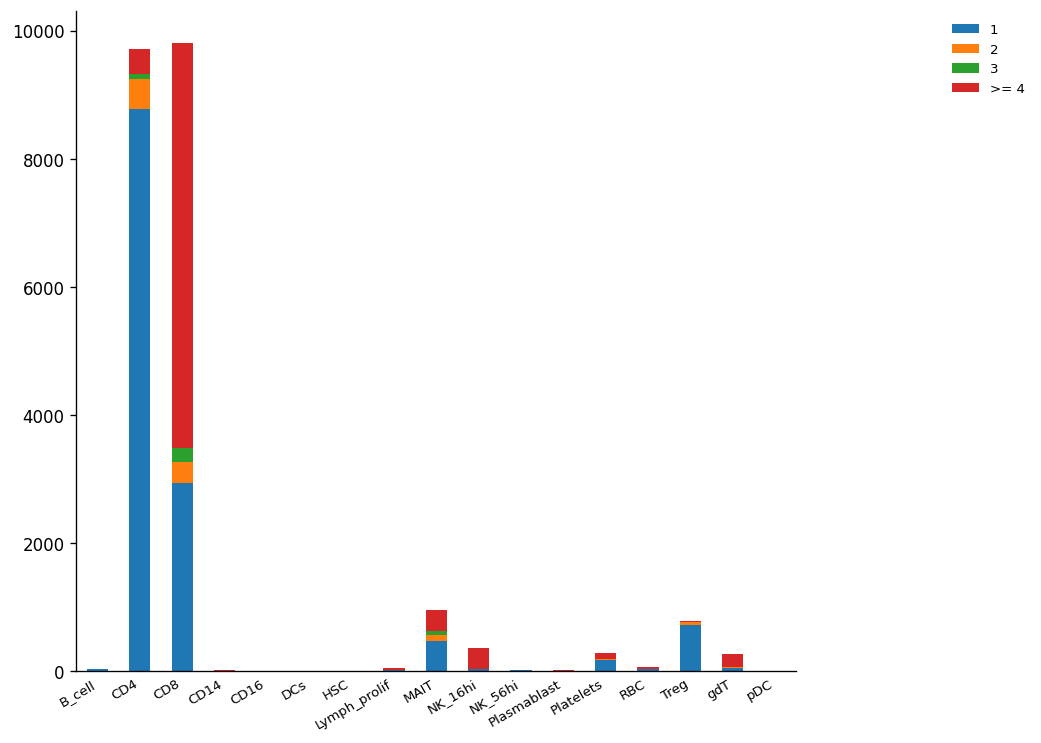

In [11]:
ir.tl.clonal_expansion(adata, target_col="cc_aa_identity")

_ = ir.pl.clonal_expansion(
    adata,
    groupby="initial_clustering",
    target_col="cc_aa_identity",
    clip_at=4,
    normalize=False,
    figsize=[10, 10],
)

The plot above tells us that CD4+ is the most abundant cell type. However, CD8+ shows the highest number of expanded clonotypes, which could be possible by the positive selection of CD8+ effector cells.

Another way to observe clonal expansion is by normalizing the size of cell-type clusters. Here, the clonal expansion differences between CD4+ and CD8+ are easier to observe.

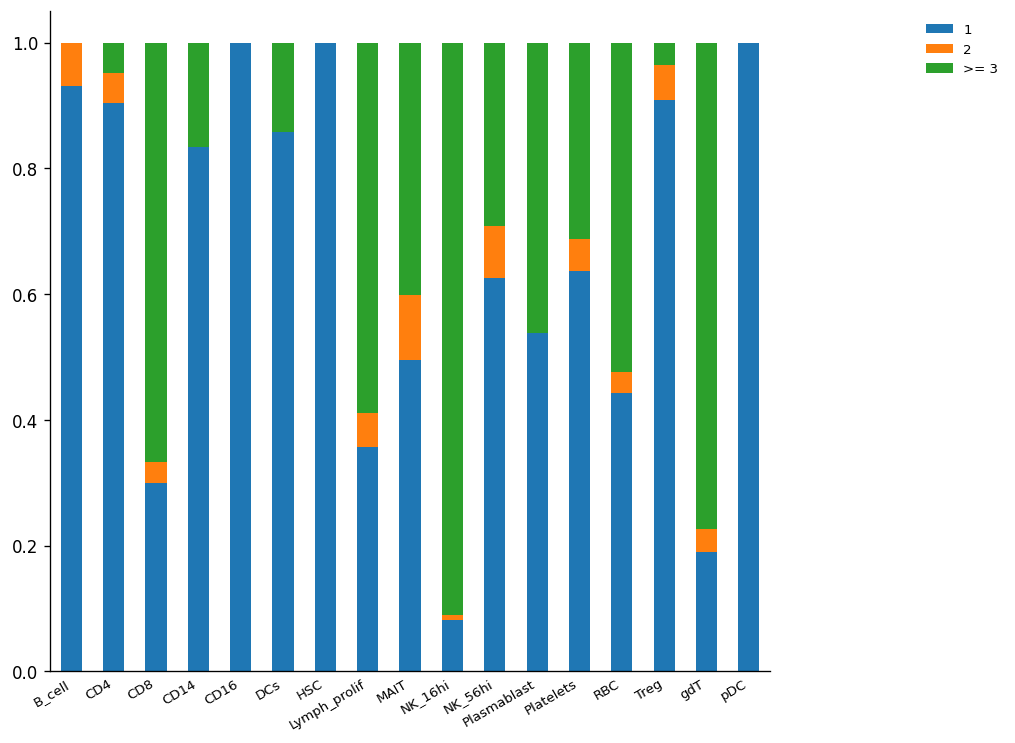

In [12]:
_ = ir.pl.clonal_expansion(
    adata, "initial_clustering", target_col="cc_aa_identity", figsize=[10, 10]
)

Another way to observe the clonal expansion phenomenon is through the loss of alpha diversity. The expanded clones are less diverse because there are more individuals (cells) from the same type (clone) inside a specific population (cluster of cells). There are different types of diversity and different ways to calculate this according to different assumptions. However, in TCR analysis, we are interested in correlate this concept with the clonality expansion per cluster as the reduction of variability in a specific set of features (alpha diversity).

The plot below reflects this assumption, the alpha diversity of CD8+ is lower than CD4+ due to the possible clonal expansion from CD8+ effector cells reducing their diversity in consideration of the total cells conforming to the CD8+ cluster. The same observation is repeated for clusters NK_16hi and gdT-cell, which are highly expanded, as the clonal expansion plot demonstrates (see above).

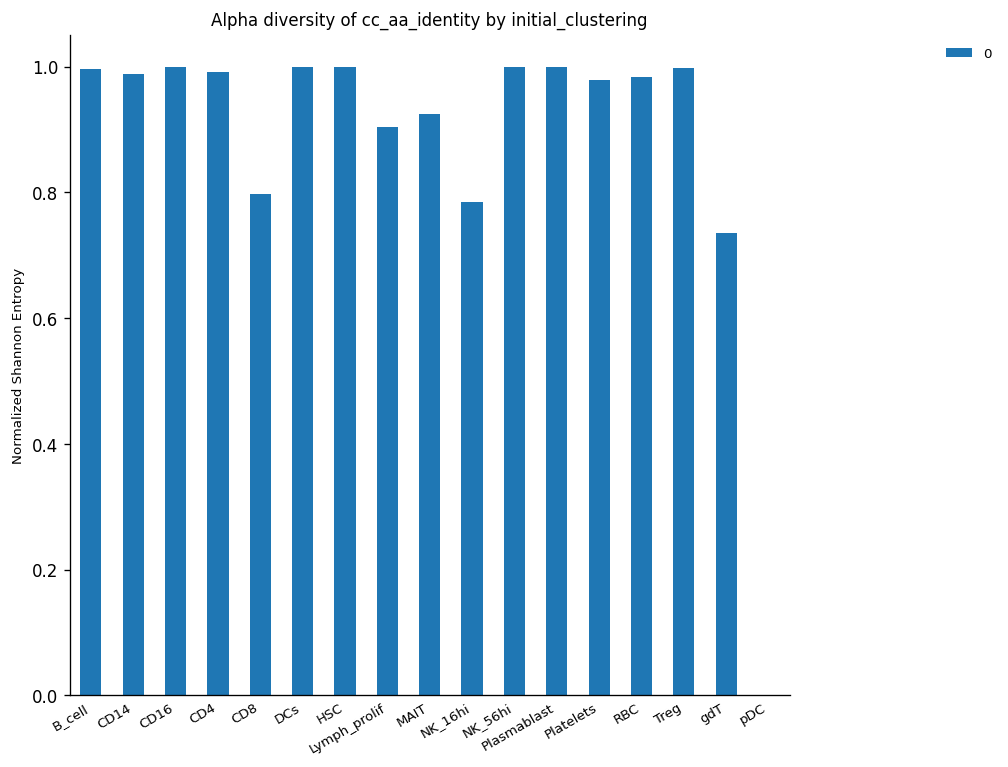

In [13]:
_ = ir.pl.alpha_diversity(
    adata, groupby="initial_clustering", target_col="cc_aa_identity", figsize=[10, 10]
)

## Clonotype abundance

Contrary to diversity, which is expected to be reduced when clonal expansion is gained, regarding a cluster of cells, the abundance is expected to be gained when clonal expansion occurred due to the increase in the number of cells from the same clone.

The next function helps to plot the most abundant clonotypes showing the ID, the number of cells and the cluster (cell type) the specific clonotype belongs to. Here, we highlight the ten most abundant clonotypes.

... storing 'cc_aa_identity' as categorical
... storing 'clonal_expansion' as categorical
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

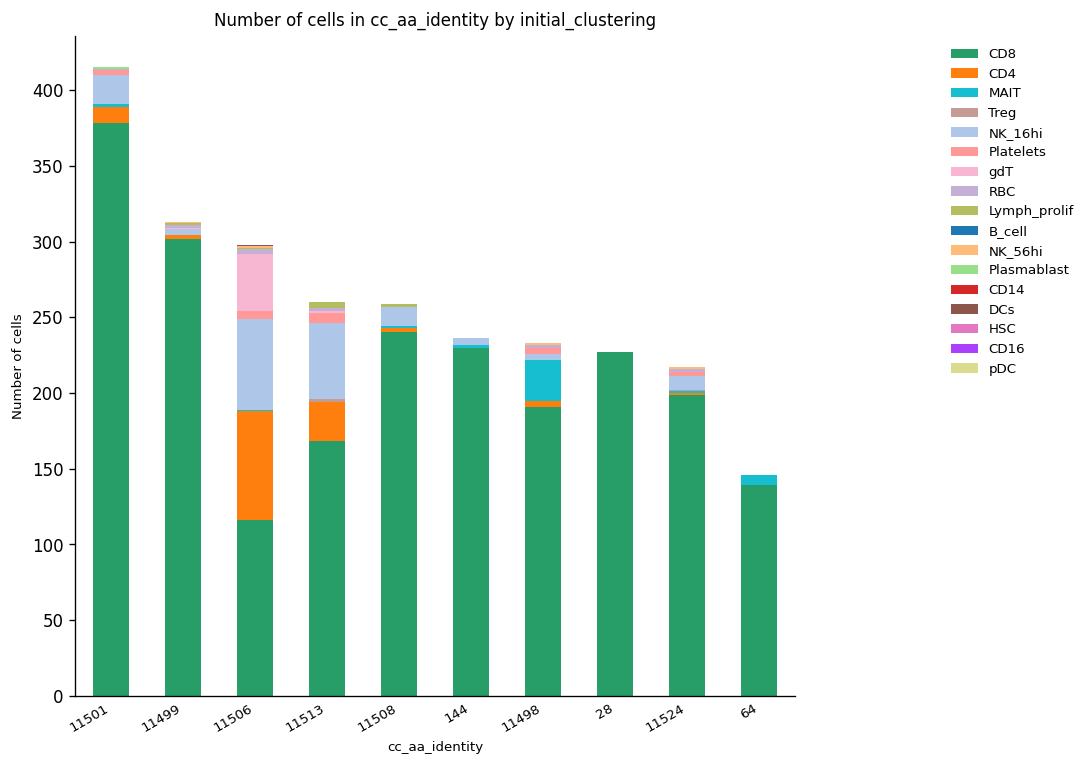

In [14]:
_ = ir.pl.group_abundance(
    adata,
    groupby="cc_aa_identity",
    target_col="initial_clustering",
    max_cols=10,
    figsize=[10, 10],
)

The plot above showed that clonotype ID 11501 was the most expanded and is present in more than one cell cluster. However, according to the previous results, it is expected this clonotype corresponds to the same sample and therefore is involved in one specific condition (COVID or healthy). Hence, the repetition of this plotting is worth it to check this assumption.

Furthermore, the clonal expansion is expected to occur in response to an immune event, which means it is expected to the total, or at least the majority of the most expanded clones belong to the COVID set of patients.

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

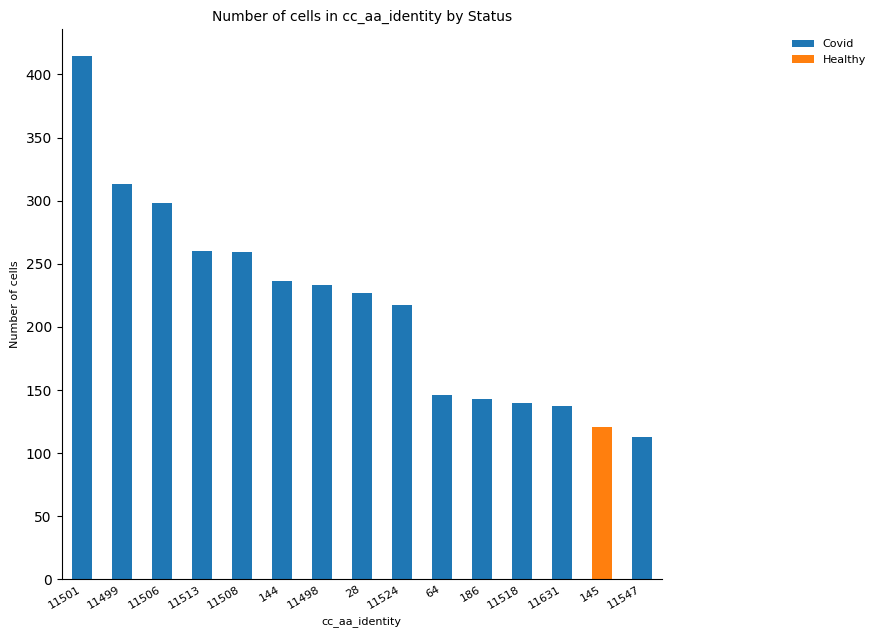

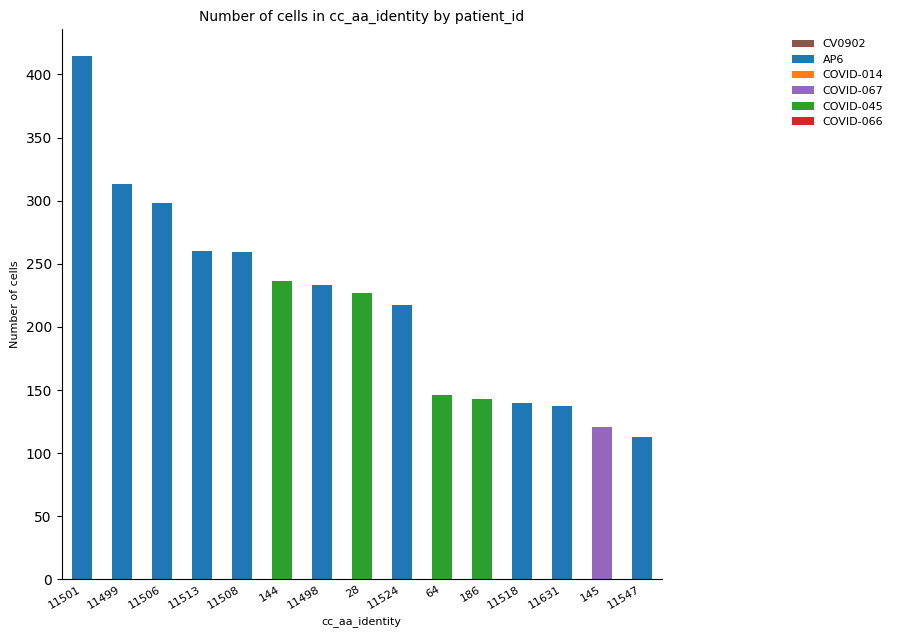

In [15]:
# By condition

_ = ir.pl.group_abundance(
    adata,
    groupby="cc_aa_identity",
    target_col="Status",
    max_cols=15,
    fig_kws={"dpi": 100},
    figsize=[10, 10],
)

# By sample

_ = ir.pl.group_abundance(
    adata,
    groupby="cc_aa_identity",
    target_col="patient_id",
    max_cols=15,
    fig_kws={"dpi": 100},
    figsize=[10, 10],
)

## Gene usage

In the previous steps, we analyzed the data regarding clones, their expansion, and their diversity and abundance. However, it is possible to analyze the data to describe the specific V(D)J gene segments, their abundances across the different cell clusters, and their specific combination resulting in the immune receptors.

As described in the introduction, there are shreds of evidence of selective selection of gene segments privileging the use of some gene segments over the rest of them. Therefore, the first step is to detect those segments privileged for this phenomenon via abundance analysis, the assumption behind is straightforward, if one gene segment is highly abundant, it means it was selectively chosen in IR final arrangement.

We calculated the abundances for the V segment in the VJ chain using the same function to clone abundance calculation. The sequence with ID TRAV19 was the most abundant V gene, and it was present in CD8+ cells mainly. Otherwise, the second most abundant V segment (TRAV29/DV5) was mostly selected for the CD4+ cell cluster. 

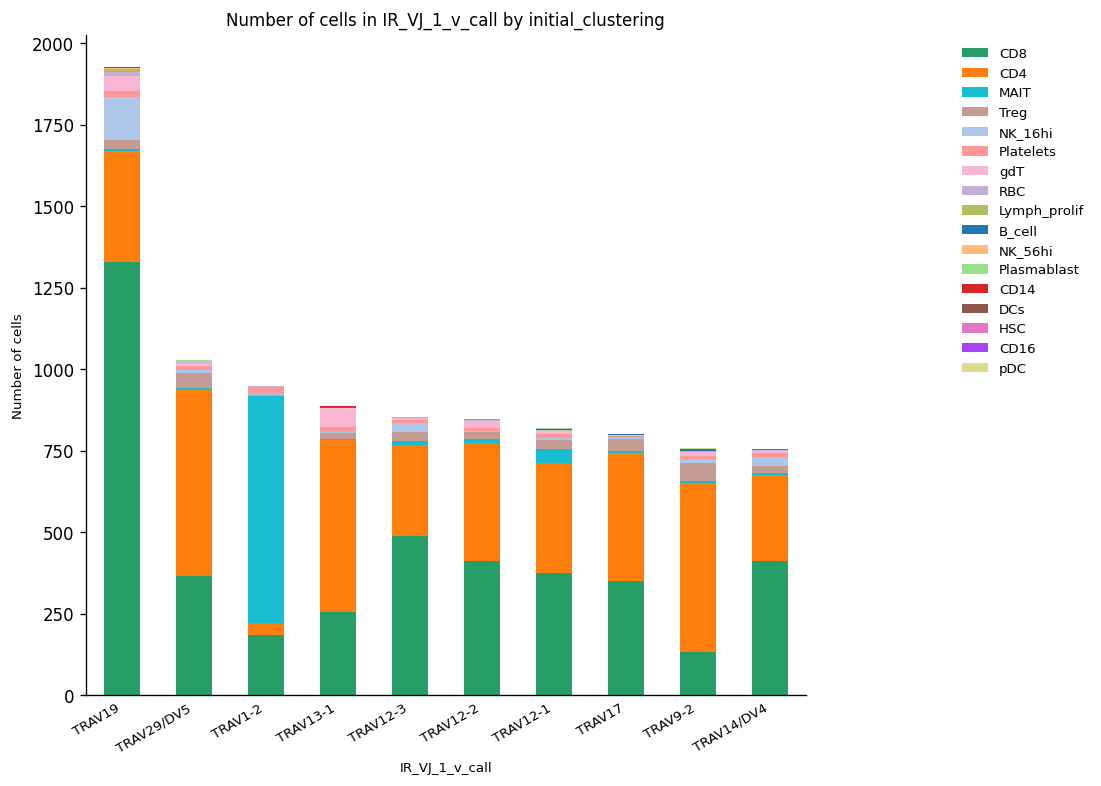

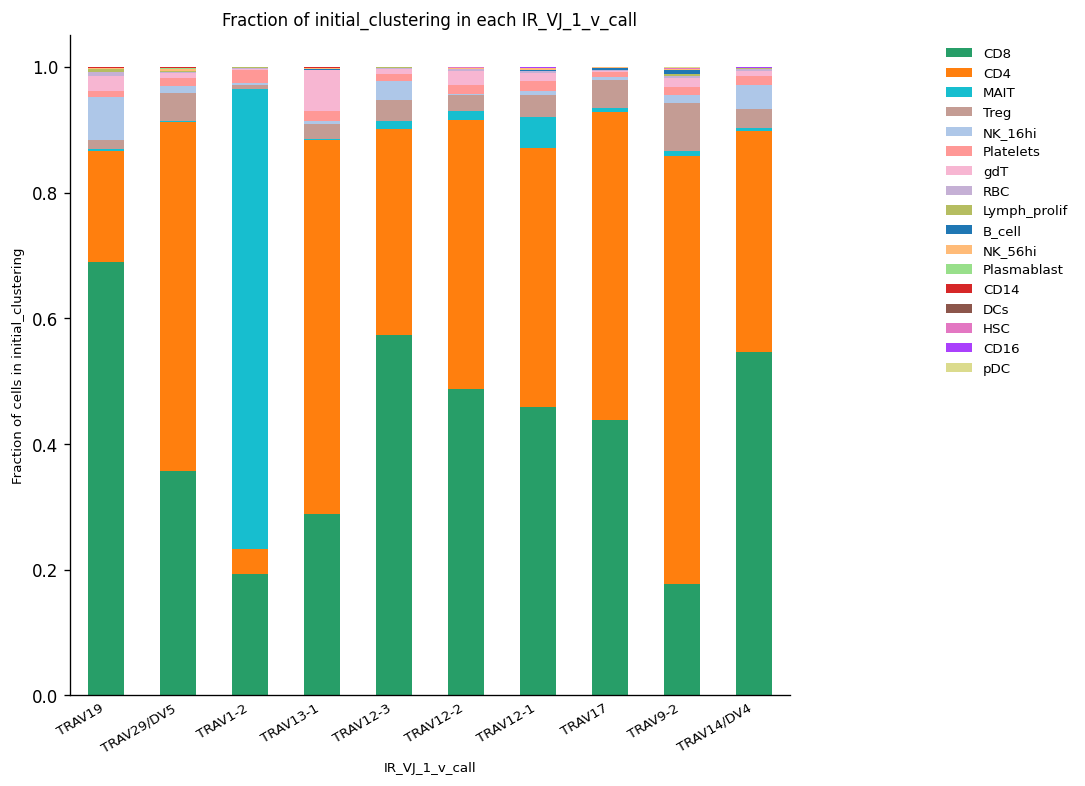

In [16]:
_ = ir.pl.group_abundance(
    adata,
    groupby="IR_VJ_1_v_call",
    target_col="initial_clustering",
    normalize=False,
    max_cols=10,
    figsize=[10, 10],
)

# Normalized abundances

_ = ir.pl.group_abundance(
    adata,
    groupby="IR_VJ_1_v_call",
    target_col="initial_clustering",
    normalize=True,
    max_cols=10,
    figsize=[10, 10],
)

On the other hand, it is possible to choose the list of segments of interest and detect the fraction of cells for which those segments are represented across the different clusters of cells.

Here, we are showing a list of four V segments for the VDJ chain. From them, the TRBV18 segment was the most abundant in the majority of cell clusters.

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


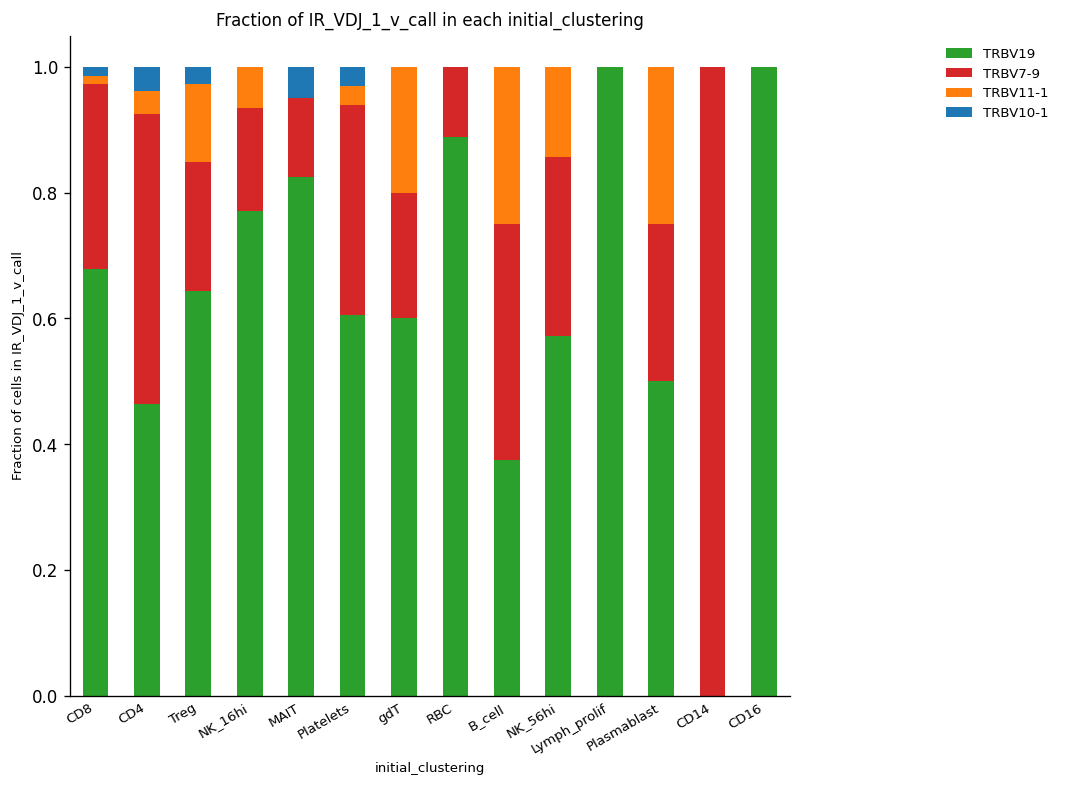

In [17]:
_ = ir.pl.group_abundance(
    adata[
        adata.obs["IR_VDJ_1_v_call"].isin(
            ["TRBV19", "TRBV10-1", "TRBV11-1", "TRBV7-9"]
        ),
        :,
    ],
    groupby="initial_clustering",
    target_col="IR_VDJ_1_v_call",
    normalize=True,
    figsize=[10, 10],
)

Beyond the individual analysis and specific V(D)J segments according to abundances, it is possible to visualize a specific combination of V, D, and J segments for the total number of cells (see below). It provides valuable information regarding how the different privileged segments are combined to create different alpha and beta IRs sequences and how they are related to the rest of the low-selected segments.

One assumption for this graphic would be the most abundant segments are combined expecting a kind of linear representation. However, those segments are independent of each other in the random somatic recombination, therefore, this assumption is not true.

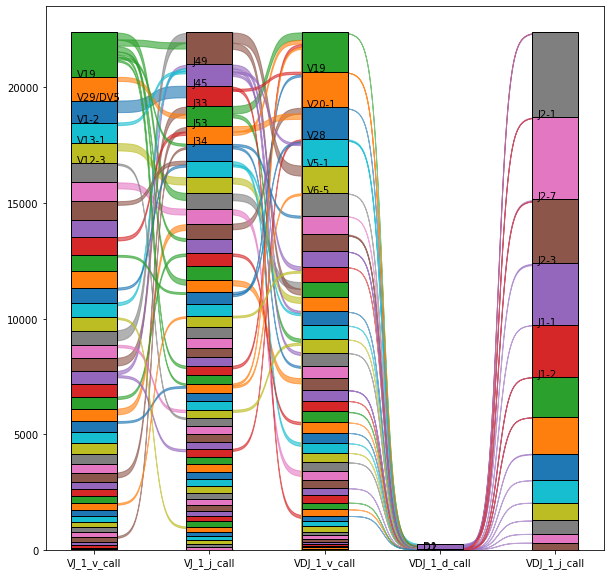

In [18]:
_ = ir.pl.vdj_usage(
    adata,
    full_combination=False,
    max_segments=None,
    max_ribbons=30,
    fig_kws={"figsize": [10, 10]},
)

The segment combination plot showed that there was just one D segment (TBRD2) for the VDJ chains detected for the set of cells and patients used here from the original experiment.

As well as the previous plots, it is possible to plot the combination of segments for a set of specific observations. In this case, we focused attention checking the combination of V(D)J segments for a set of clonotypes with positive detection of the TRBD2 segment highlighted above. In the next example, we used the first five clonotype IDs.

In [19]:
adata.obs[adata.obs["IR_VDJ_1_d_call"] == "TRBD2"].cc_aa_identity.value_counts()

5150     1
1815     1
4427     1
3500     1
4078     1
        ..
4734     0
4735     0
4736     0
4737     0
14180    0
Name: cc_aa_identity, Length: 14181, dtype: int64

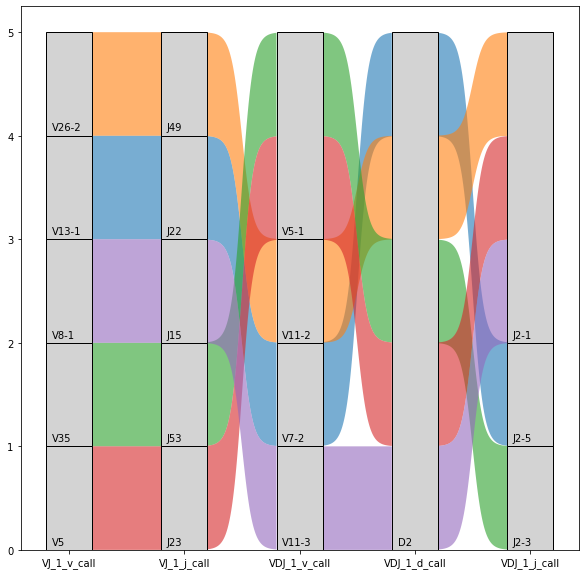

In [20]:
_ = ir.pl.vdj_usage(
    adata[
        adata.obs["cc_aa_identity"].isin(["5150", "1815", "4427", "3500", "4078"]), :
    ],
    max_ribbons=None,
    max_segments=100,
    fig_kws={"figsize": [10, 10]},
)

## Spectratype analysis

Spectratype analysis provides more information about V(D)J sequences heterogeneity. Not all IR sequences have the same number of amino acids, given the pseudo-random gene segment cleavage during somatic recombination. In addition, spectratype is another way to define immunodominance based on the most abundant sequence length. If the majority of V(D)J sequences share the same length, it means the functional chains should have the same or a similar number of amino acids.

Below, we plotted the abundances for VDJ sequences and the most common length was 15, closely followed by 14 amino acids detected in a variety of cell clusters, mainly CD4+ and CD8+. We highlight the last cell type, which was previously detected as highly clonal expanded. However, we found even VDJ sequences with lengths of 10 or 21 amino acids. However, they were strongly less represented in the general set of VDJ sequences.

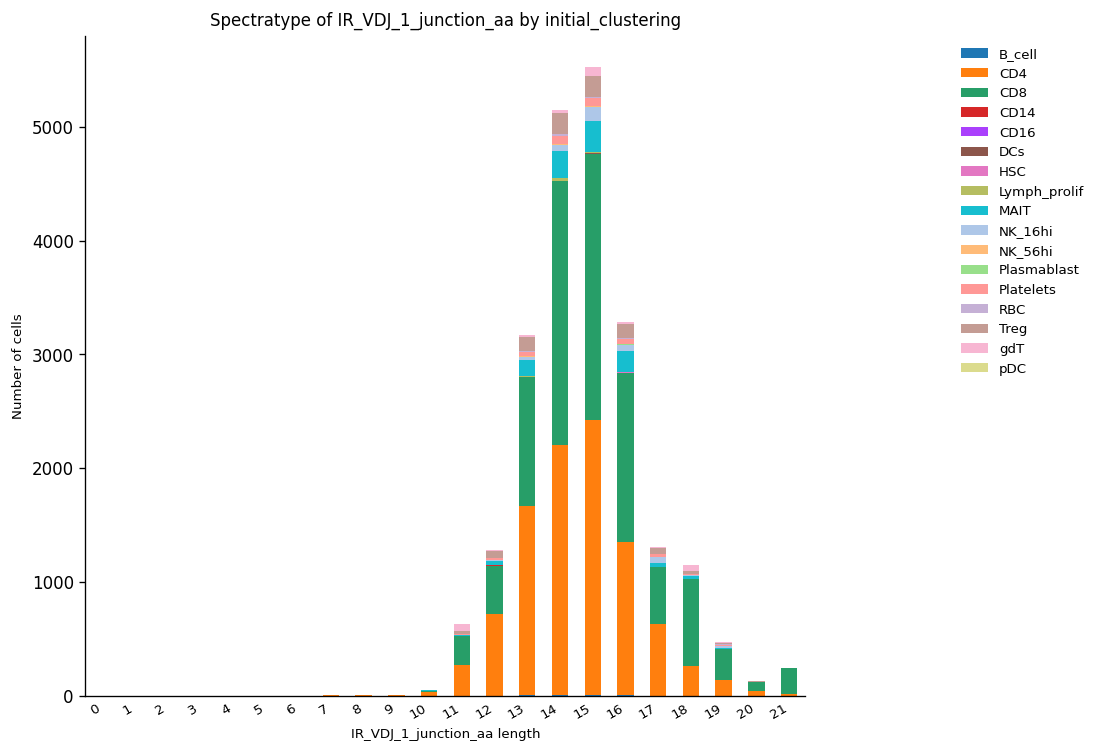

In [21]:
_ = ir.pl.spectratype(
    adata,
    cdr3_col="IR_VDJ_1_junction_aa",
    color="initial_clustering",
    viztype="bar",
    fig_kws={"dpi": 120},
    figsize=[10, 10],
)

Furthermore, it is possible to visualize the V(D)J sequence length distributions individually for each cluster of cells, which provides a better perspective of those clusters closer to the most abundant sequence length. The plot below shows how the distribution of CD4+ and CD8+ is related to the previous analysis for general length abundances and how heterogenic the distribution per cluster is, for example, in the case of gdT-cells.

/home/juan.henao/.local/lib/python3.8/site-packages/scirpy/pl/base.py:262: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(order)


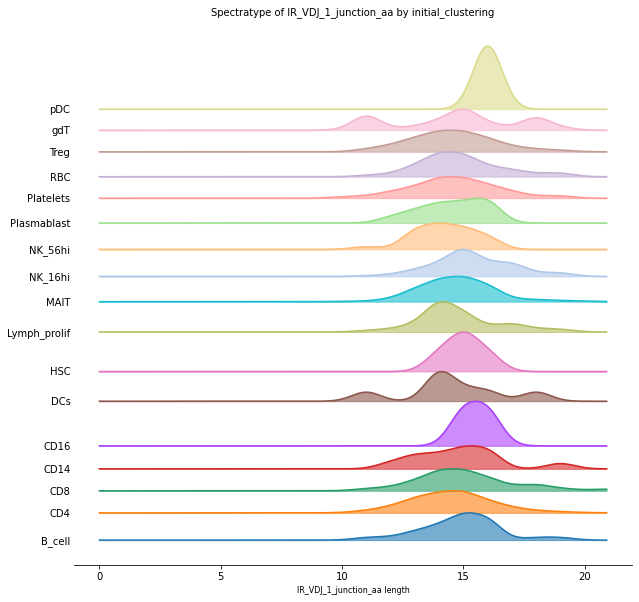

In [22]:
_ = ir.pl.spectratype(
    adata,
    cdr3_col="IR_VDJ_1_junction_aa",
    color="initial_clustering",
    viztype="curve",
    curve_layout="shifted",
    fig_kws={"figsize": [10, 10]},
    kde_kws={"kde_norm": False},
)

By exploiting the commodities provided by the AnnData object, we can extract more specific information from spectratype analysis easily. For instance, we can visualize the distribution of sequence lengths regarding a specific V(D)J gene segment according to their fraction in the cluster of cells. Here, we selected the four V segments from V(D)J chain illustrated in the last gene usage plot. Once again, they were represented mainly by sequences of length 15. TRBV5-1 was the most abundant, followed by TRBV11-3, which was represented mainly by this specific length.

/home/juan.henao/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


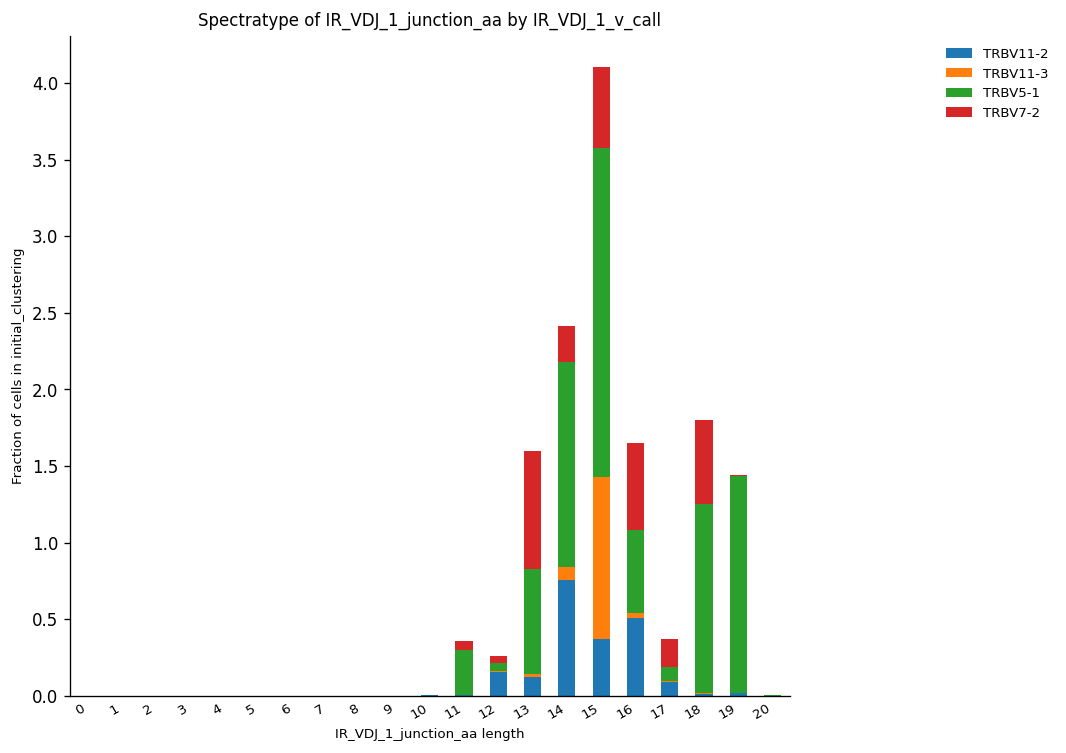

In [23]:
_ = ir.pl.spectratype(
    adata[
        adata.obs["IR_VDJ_1_v_call"].isin(
            ["TRBV5-1", "TRBV11-2", "TRBV7-2", "TRBV11-3"]
        ),
        :,
    ],
    cdr3_col="IR_VDJ_1_junction_aa",
    color="IR_VDJ_1_v_call",
    normalize="initial_clustering",
    fig_kws={"dpi": 120},
    figsize=[10, 10],
)

## Motif sequence analysis

So far, we have analyzed different properties of the IR sequences, which provides us with information we can use to establish similarities. However, it is necessary to compare the sequences per se and to be able to detect those similarities at the amino acid-specific position level. One widely used tool to do that is the generation of logo plots. They show the amino acids per position, and the size of every letter indicates how much a specific letter is repeated across all the sequences under analysis.

Considering the information we have, we can create a logo plot for all the V(D)J sequences of length 15 with one of the five V segments analyzed in the previous step.

To perform this plot, we used the *palmotif* python library, this is implemented in other libraries for TCR analysis, such as *TCRdist3*. This library uses as input a list of sequences and saves the logo plot directly to a designated file path.

In [55]:
motif = compute_motif(
    adata[
        (
            adata.obs["IR_VDJ_1_v_call"].isin(
                ["TRBV5-1", "TRBV11-2", "TRBV7-2", "TRBV11-3"]
            )
        )
        & (adata.obs["IR_VDJ_1_junction_aa"].str.len() == 15),
        :,
    ]
    .obs["IR_VDJ_1_junction_aa"]
    .to_list()
)

In [62]:
_ = svg_logo(
    motif, "../_static/images/air_repertoire/logo_motif.svg", color_scheme="taylor"
)

The result was saved as *logo_motif.svg*, and the result is the plot you can see below.

![](../_static/images/air_repertoire/logo_motif.svg)

As you can see, C-A-S are the three first amino acids for all the sequences analyzed in this example, as well F is the last amino acid for all the sequences. In addition, position 14 could be a Y, or an F, or an H, or an T. The fourth amino acid is most probable to be an S more than R or T. Those types of characterization are useful in protein profile discoveries, which are relevant in further experimental performance such as protein design.

## Repertoire comparison

The IR repertoires can be used to identify similarities between samples, which could help to understand the general response regarding the experimental perturbation. *Scirpy* allows the comparison between samples through the construction of a matrix with the abundances of clonotypes per sample (`df`), a Jaccard distance between samples (`dst`), and a linkage for hierarchical clustering (`lk`).

In [24]:
df, dst, lk = ir.tl.repertoire_overlap(
    adata, "patient_id", target_col="cc_aa_identity", inplace=False
)

In [25]:
df

cc_aa_identity,0,1,2,3,4,5,6,7,8,9,...,14171,14172,14173,14174,14175,14176,14177,14178,14179,14180
patient_id,,,,,,,,,,,,,,,,,,,,,
AP6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COVID-014,71.0,0.0,0.0,1.0,4.0,0.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
COVID-045,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
COVID-066,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
COVID-067,0.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
CV0902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
dst

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99982818, 1.        ])

In [27]:
lk

array([[3.        , 5.        , 0.99982818, 2.        ],
       [0.        , 1.        , 1.        , 2.        ],
       [2.        , 7.        , 1.        , 3.        ],
       [6.        , 8.        , 1.        , 5.        ],
       [4.        , 9.        , 1.        , 6.        ]])

The previous data can be displayed as a heatmap which facilitates the interpretation of the results. For instance, the patients *COVID-066* and *CV0902* are the most similar, although with a low distance between them. Curiously both samples come from different centers, *COVID-066* from Newcastle and *CV0902* from Cambridge.

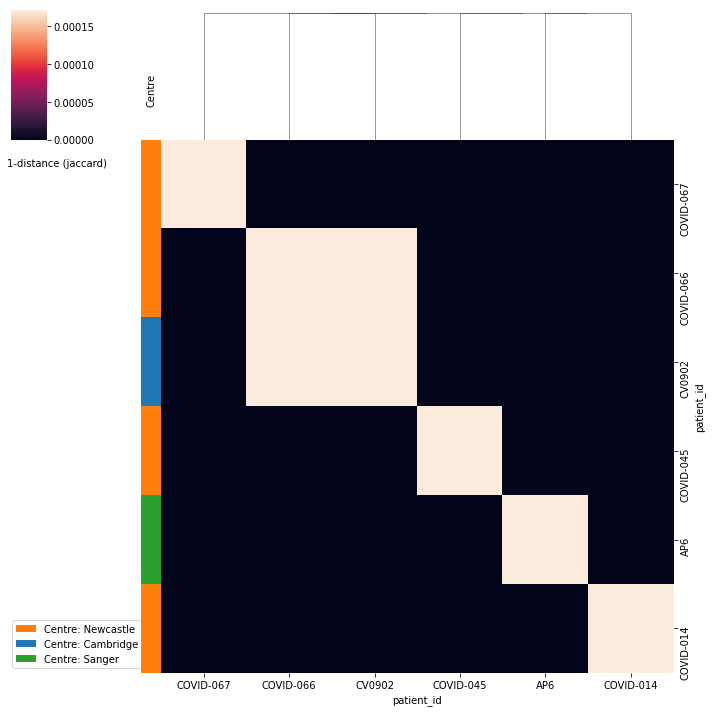

In [28]:
ir.pl.repertoire_overlap(
    adata, "patient_id", target_col="cc_aa_identity", heatmap_cats=["Centre"]
)

Once sample similarities are detected, it is possible to analyze the pair of samples of interest. One way to do it is by comparing the clonotype sizes (number of cells) and the number of clonotypes (IDs) sharing a specific size. Visually, a scatter plot allows easy interpretations of the comparison result. Here, we compared the samples *COVID-067* versus *CV0902* in consideration of the heatmap interpretation above.

The scatterplot below shows that both samples are characterized by a high number of clonotypes with small size. Specifically, *COVID-067* presents a few clonotypes with high number of cells (size) than *CV0902*.

No handles with labels found to put in legend.


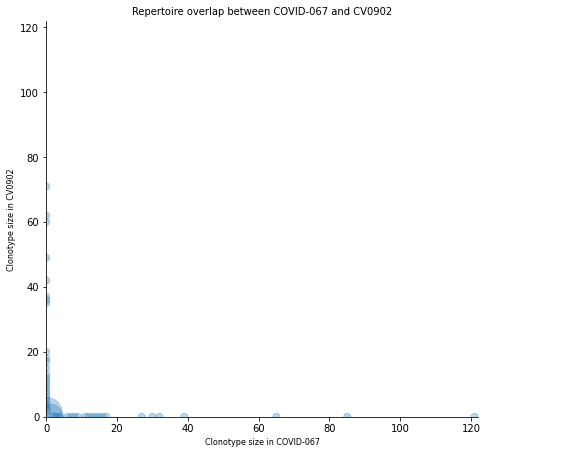

In [43]:
_ = ir.pl.repertoire_overlap(
    adata,
    "patient_id",
    pair_to_plot=["COVID-067", "CV0902"],
    fig_kws={"figsize": [10, 10]},
)

## BCR Data Analysis with Dandelion

So far, we have shown all the analyses you can perform to characterize the T-cell receptor repertoire, including the cell clones' identification and expansion. Besides, the representation in both, cell clusters and biological samples. Furthermore, the sequence motif for V(D)J gene segments, which is highlighted by interpretation of gene usage and spectratype results.

Those methods could be applied to characterize B-cell receptors as well {cite}`gupta2015change`. However, over the lifetime of B-cells mutual mutations occur in the V gene segment helping the low-affinity receptors to acquire a high affinity phenotype. This process is known as **affinity maturation**, and the high rate of mutual mutations (~10000 more than germline cells) is called **somatic hypermutation** {cite}`papavasiliou2002somatic`. Therefore, the clonotype definition for B-cells should take this phenomenon into account. One way to deal with this is through distance-based clonotype analysis.

Here, we use **Dandelion**, a python library focused on BCR analysis which interoperates with *Scanpy* and *Scirpy* and provides a BCR distance-based method for clone definition, which is explained below in more detail {cite}`stephenson2021single`.

In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)

import dandelion as ddl
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scirpy as ir
from palmotif import compute_motif, svg_logo

warnings.simplefilter(action="ignore", category=pd.errors.DtypeWarning)

In [2]:
sc.logging.print_versions()

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.8.0
scanpy      1.8.2
sinfo       0.3.4
-----
Bio                         1.79
Levenshtein                 NA
PIL                         8.4.0
adjustText                  NA
airr                        1.4.1
anyio                       NA
asciitree                   NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.0.9
certifi                  

As well as the TCR analysis described previously, we need to load the data as *.h5ad* format obtained after the pre-processing step. Besides, to improve the runtime of this tutorial, we will work with a subset of samples that allow us to explore the BCR receptors properly and perform the necessary comparisons between conditions.

In [3]:
path_data = "/home/icb/juan.henao/BestPracticeStart/data"

path_gex = f"{path_data}/BCR_filtered.h5ad"
adata_bcr = sc.read(path_gex)

In [4]:
adata = adata_bcr[adata_bcr.obs["patient_id"].isin(["COVID-064", "COVID-014"])].copy()

## Dandelion interoperability

Dandelion uses its own object to locate the BCR data. Therefore, this package provides a function to translate to annData and be able to use the functionalities from Scanpy and Scirpy.

Previously, we loaded our pre-processed data into an annData object. Therefore, we should relocate the information into the correct format to use Dandelion. The next piece of code shows how easy is the interoperability between both objects.

In [5]:
vdjx = ddl.from_scirpy(adata)
vdjx

Dandelion class object with n_obs = 6366 and n_contigs = 16953
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'c_call', 'consensus_count', 'duplicate_count', 'locus', 'cell_id', 'multi_chain', 'receptor_subtype', 'chain_pairing', 'receptor_type', 'is_cell', 'high_confidence', 'patient_id', 'rearrangement_status'
    metadata: 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangemen

## Clonotype definition

Before the clonotype definition for our BCR data, the empty cells (*NA data*) should be removed, and receptor lengths must be calculated.

In [6]:
vdjx.data["v_call"].replace("", np.nan, inplace=True)
vdjx.data.dropna(subset=["v_call"], inplace=True)

vdjx.data["j_call"].replace("", np.nan, inplace=True)
vdjx.data.dropna(subset=["j_call"], inplace=True)

vdjx.data["junction_aa"].replace("", np.nan, inplace=True)
vdjx.data.dropna(subset=["junction_aa"], inplace=True)

vdjx.data["junction_length"] = [len(a) for a in vdjx.data["junction_aa"]]

Dandelion defines clonotypes using a substitution model based on distances. It was created specifically to deal with the problem of somatic hypermutation in B-cells {cite}`yaari2013models` {cite}`cui2016model`. This model was available in the **Immcantation** suite as an R package {cite}`gupta2015change` {cite}`vander2014presto`. However, Dandelion makes possible to use it, avoiding the complication of moving between code languages and keeping the interoperability with *Scanpy* and *Scirpy*.

The model was created based on the probability of a punctual nucleotide change, considering the influence of the immediate two down- and upstream nucleotides {cite}`yaari2013models`. This methodology considered all the possible different 5-mers combinations just for the synonym mutation cases, i.e., those changes where the amino acid represented by the {term}`codon` is not modified {cite}`yaari2013models`.

Furthermore, Dandelion considers a model of substitution rates for single nucleotide instead of the 5-mer model. Therefore, all the substitutions are not changing, and they are displayed in the table below:

* Human substitution model {cite}`yaari2013models`:

| Nucleotide | A | C | G | T | N |
| ---------- | - | - | - | - | - |
| A | 0 | 1.21 | 0.64 | 1.16 | 0 |
| C | 1.21 |  0 | 1.16 | 0.64 | 0 |
| G | 0.64 | 1.16 | 0 | 1.21 | 0 |
| T | 1.16 | 0.64 | 1.21 | 0 | 0 |
| N | 0 | 0 | 0 | 0 | 0 |

* Mice substitution model {cite}`cui2016model`:

| Nucleotide | A | C | G | T | N |
| ---------- | - | - | - | - | - |
| A | 0 | 1.51 | 0.32 | 1.17 | 0 |
| C | 1.51 | 0 | 1.17 | 0.32 | 0 |
| G | 0.32 | 1.17 | 0 | 1.51 | 0 |
| T | 1.17 | 0.32 | 1.51 | 0 | 0 |
| N | 0 | 0 | 0 | 0 | 0 |

The clonotype definition based on distance requires a threshold value definition to allow the separation into close related receptor sequences, which are interpreted as clonal related. Dandelion wrapped the functionalities from **Immcantation** to choose this value based on distance calculation for those receptor sequences with the same V and J segment and the same length. The distribution of the distances is expected to be bimodal, being the first mode composed by closed-related sequences, and the second mode by singletons {cite}`gupta2015change`. The threshold is selected as the breakpoint between both modes.

In [7]:
ddl.pp.calculate_threshold(vdjx, model="hh_s5f", plot=False)
vdjx.threshold

/opt/python/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:59: UserWarning: Error while trying to convert the column "productive". Fall back to string conversion. The error is: Series can only be of one type, or None (and here we have <class 'str'> and <class 'bool'>).
R[write to console]: Error in (function (db, sequenceColumn = "junction", vCallColumn = "v_call",  : 
  The locus column contains invalid loci annotations.



0.13319079238387194

We have already chosen the model to calculate the distances between receptors and performed the threshold value selection. Therefore, the next step is the clonotype definition by itself.

In [8]:
ddl.tl.define_clones(vdjx, key_added="changeo_clone_id", model="hh_s5f")

       START> DefineClones
        FILE> dandelion_define_clones_heavy-clone.tsv
   SEQ_FIELD> junction
     V_FIELD> v_call
     J_FIELD> j_call
 MAX_MISSING> 0
GROUP_FIELDS> None
      ACTION> set
        MODE> gene
    DISTANCE> 0.13319079238387194
     LINKAGE> single
       MODEL> hh_s5f
        NORM> len
         SYM> avg
       NPROC> 1

PROGRESS> [Grouping sequences] 21:28:26 (6828) 0.0 min

PROGRESS> [Assigning clones] 21:28:31 |####################| 100% (6,828) 0.1 min

 OUTPUT> dandelion_define_clones_heavy-clone.tsv
 CLONES> 4741
RECORDS> 6828
   PASS> 6828
   FAIL> 0
    END> DefineClones



Once the clonotypes are defined, we need to create the network layout for visualization. Dandelion, as well as *Scirpy*, use *igraph* layouts to visualize clonotype networks. Here, we used **sfdp** because it is computationally less expensive than the rest of the methods available.

In [9]:
ddl.tl.generate_network(
    vdjx, key="sequence_alignment", layout_method="sfdp", clone_key="changeo_clone_id"
)

Setting up data: 14530it [00:01, 10889.53it/s]
Generating edge list :   0%|          | 0/220 [00:00<?, ?it/s]                                                                                       /home/juan.henao/.local/lib/python3.8/site-packages/dandelion/tools/_network.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Linking edges : 100%|██████████| 4450/4450 [00:02<00:00, 1500.32it/s]                                                                                


To benefit from faster layout computation, please install graph-tool: conda install -c conda-forge graph-tool


To visualize the results, *Dandelion* takes advantage of the interoperability with *Scanpy*. Therefore, it is necessary to do the translation from the Dandelion into an annData object to perform the visualization. Additionally, considering that the clonotype definition was based on a distance between the different BCR sequences, it is useful to add an additional feature related to the weight (distance) between BCRs (nodes), improving the final plot observation.

... storing 'changeo_clone_id' as categorical
... storing 'locus_VDJ' as categorical
... storing 'locus_VJ' as categorical
... storing 'productive_VDJ' as categorical
... storing 'productive_VJ' as categorical
... storing 'v_call_VDJ' as categorical
... storing 'd_call_VDJ' as categorical
... storing 'j_call_VDJ' as categorical
... storing 'v_call_VJ' as categorical
... storing 'j_call_VJ' as categorical
... storing 'c_call_VDJ' as categorical
... storing 'c_call_VJ' as categorical
... storing 'junction_VDJ' as categorical
... storing 'junction_VJ' as categorical
... storing 'junction_aa_VDJ' as categorical
... storing 'junction_aa_VJ' as categorical
... storing 'v_call_B_VDJ' as categorical
... storing 'd_call_B_VDJ' as categorical
... storing 'j_call_B_VDJ' as categorical
... storing 'v_call_B_VJ' as categorical
... storing 'j_call_B_VJ' as categorical
... storing 'c_call_B_VDJ' as categorical
... storing 'c_call_B_VJ' as categorical
... storing 'productive_B_VDJ' as categorical
... 

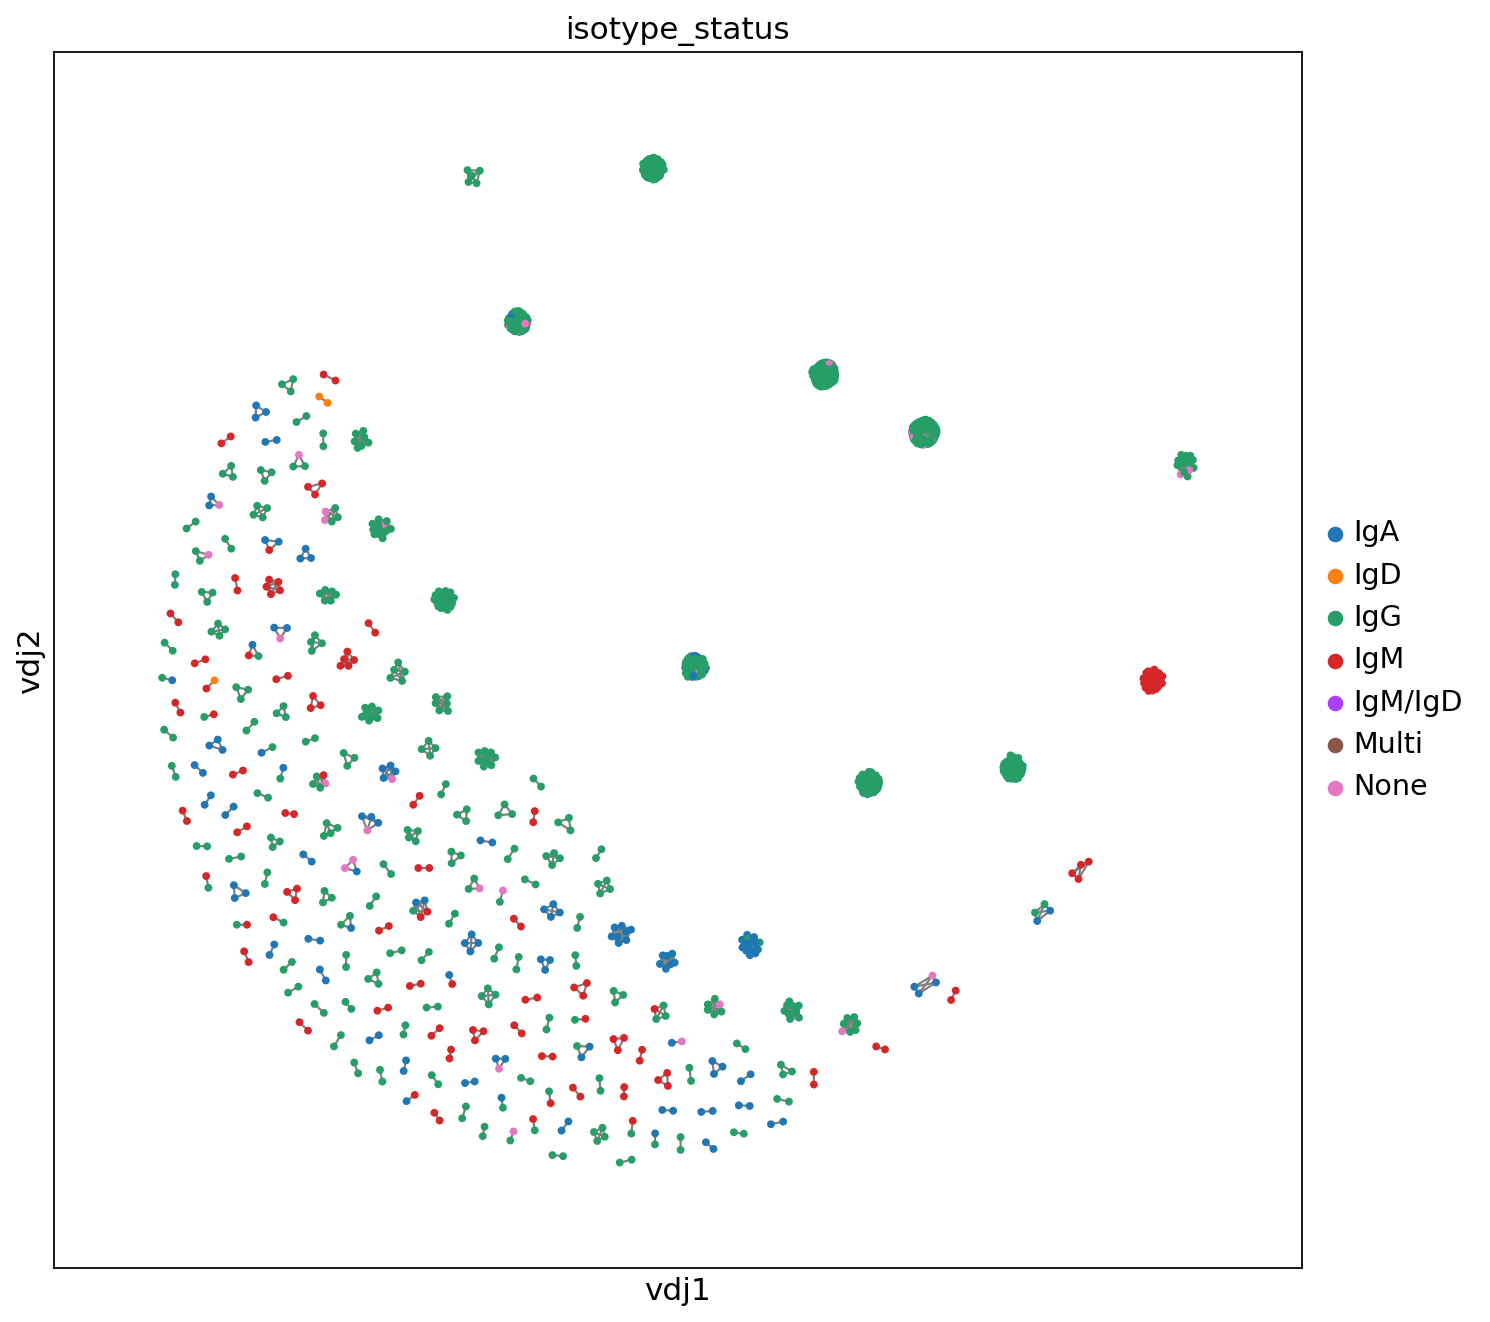

In [10]:
ddl.tl.transfer(adata, vdjx, clone_key="changeo_clone_id", expanded_only=True)

edgeweights = [
    1 / (e + 1) for e in ddl.tl.extract_edge_weights(vdjx)
]  # invert and add 1 to each edge weight (e) so that distance of 0 becomes the thickest edge
# therefore, the thicker the line, the shorter the edit distance.

sc.set_figure_params(figsize=[10, 10])
_ = ddl.pl.clone_network(
    adata,
    color=["isotype_status"],
    legend_fontoutline=3,
    edges_width=edgeweights,
    size=50,
)

Compared to *Scirpy*, the clonotypes visualization in *Dandelion* does not show their sizes (number of cells). This process should be done separately, i.e., first, it is necessary to calculate the size of the clones and transfer this information to the *annData* object to perform the visualization via *Scanpy*.

In [11]:
ddl.tl.clone_size(vdjx, clone_key="changeo_clone_id")
ddl.tl.transfer(adata, vdjx, clone_key="changeo_clone_id")

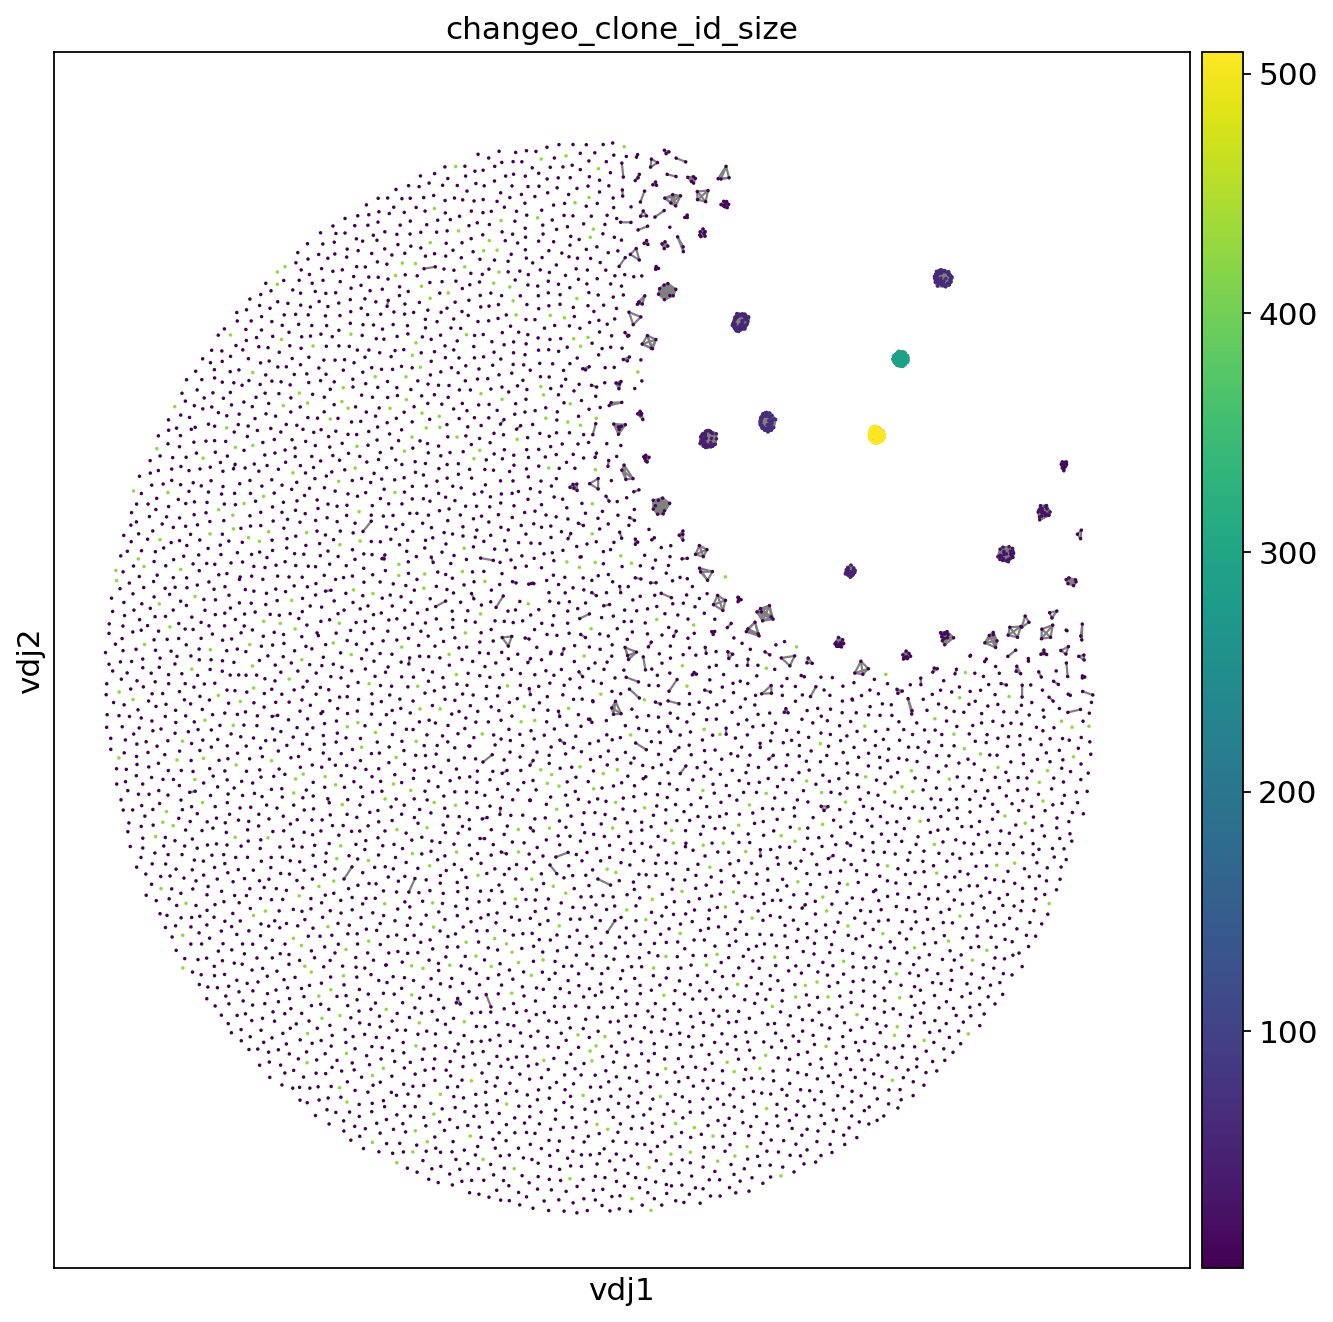

In [12]:
sc.set_figure_params(figsize=[10, 10])

_ = ddl.pl.clone_network(
    adata,
    color=["changeo_clone_id_size"],
    legend_loc="none",
    legend_fontoutline=3,
    edges_width=1,
    size=10,
)

Additionally, it is possible to fix a maximum size to establish a threshold to get a grouped visualization of the clonotypes.

In [13]:
ddl.tl.clone_size(vdjx, clone_key="changeo_clone_id", max_size=50)
ddl.tl.transfer(adata, vdjx, clone_key="changeo_clone_id")

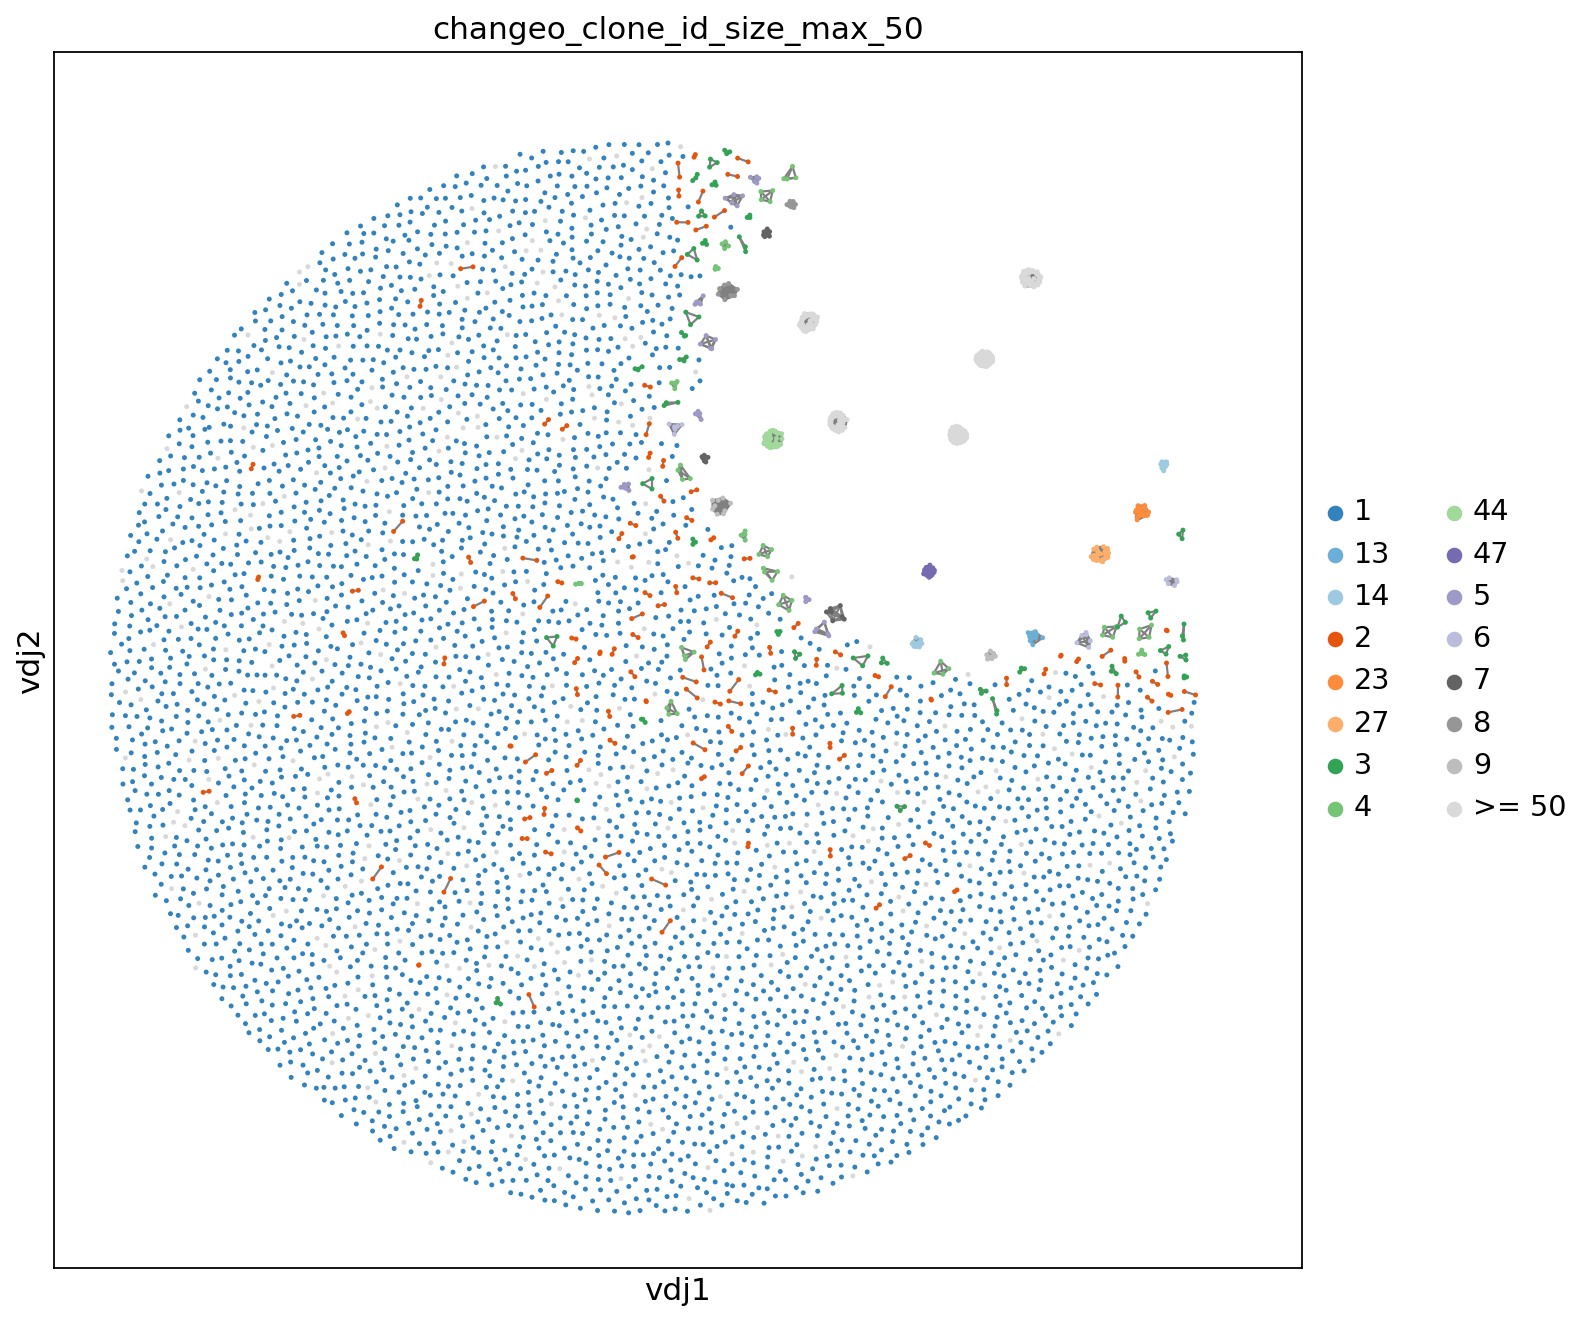

In [14]:
_ = ddl.pl.clone_network(
    adata,
    color=["changeo_clone_id_size_max_50"],
    ncols=2,
    legend_fontoutline=3,
    edges_width=1,
    palette="tab20c",
    size=20,
)

# Gene segment usage

As well as TCR analysis, we can observe the gene segment preference usage. *Dandelion* allows analyzing this phenomenon by visualizing the abundance of specific segments and chains.

Let us take the V gene segment in the heavy chain (V(D)J) for the clonotypes composed of more than 50 cells. Notice we are ignoring multi-chain, given they are not viable receptors. *Dandelion* by default, do not remove them. It could be a source of misinterpretations.

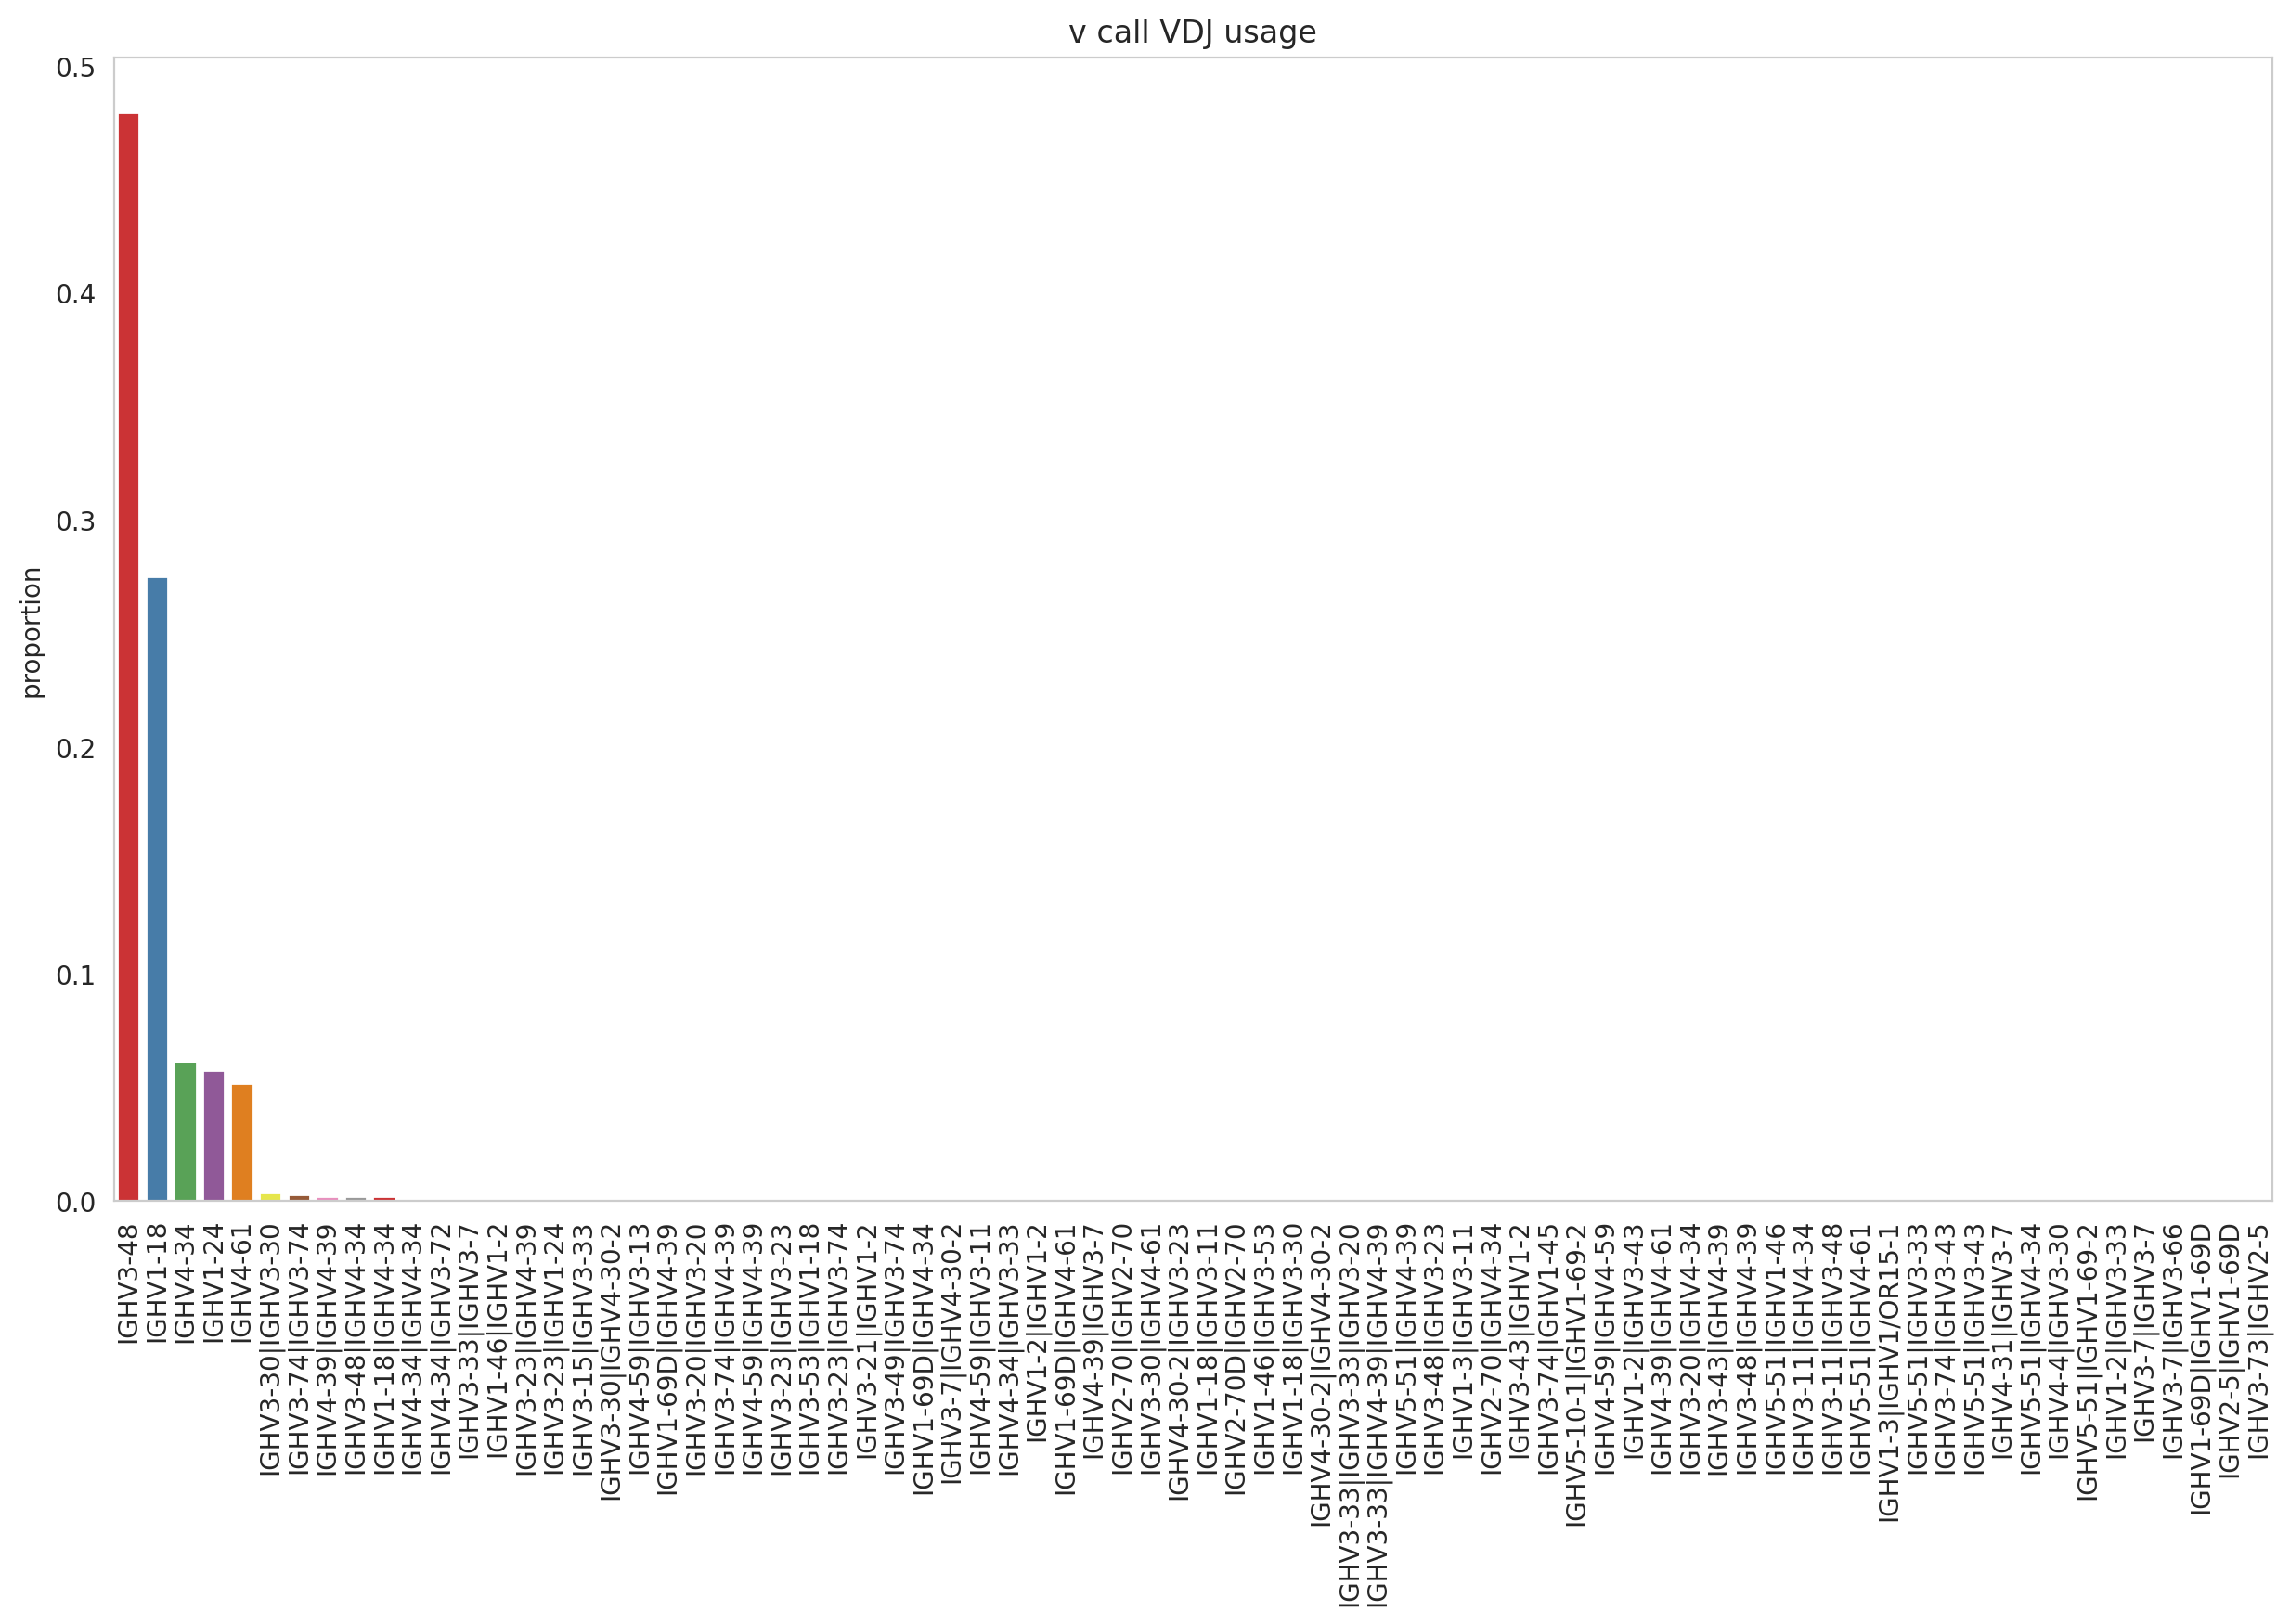

In [15]:
mpl.rcParams.update(mpl.rcParamsDefault)
_ = ddl.pl.barplot(
    vdjx[vdjx.metadata.isotype_status != "Multi"],
    clone_key="changeo_clone_id",
    color="v_call_VDJ",
    min_clone_size=50,
    figsize=[15, 8],
)

As you can appreciate before, **IGHV3-48** and **IGHV1-18** were the gene segments consistently more abundant in comparison to the rest of the segments in the plot, providing evidence of strong V gene preferential usage for the samples analyzed here.

The previous analysis can be improved by just adding information for the visualization. For example, let us see if those privilege V segments are shared between isotypes.

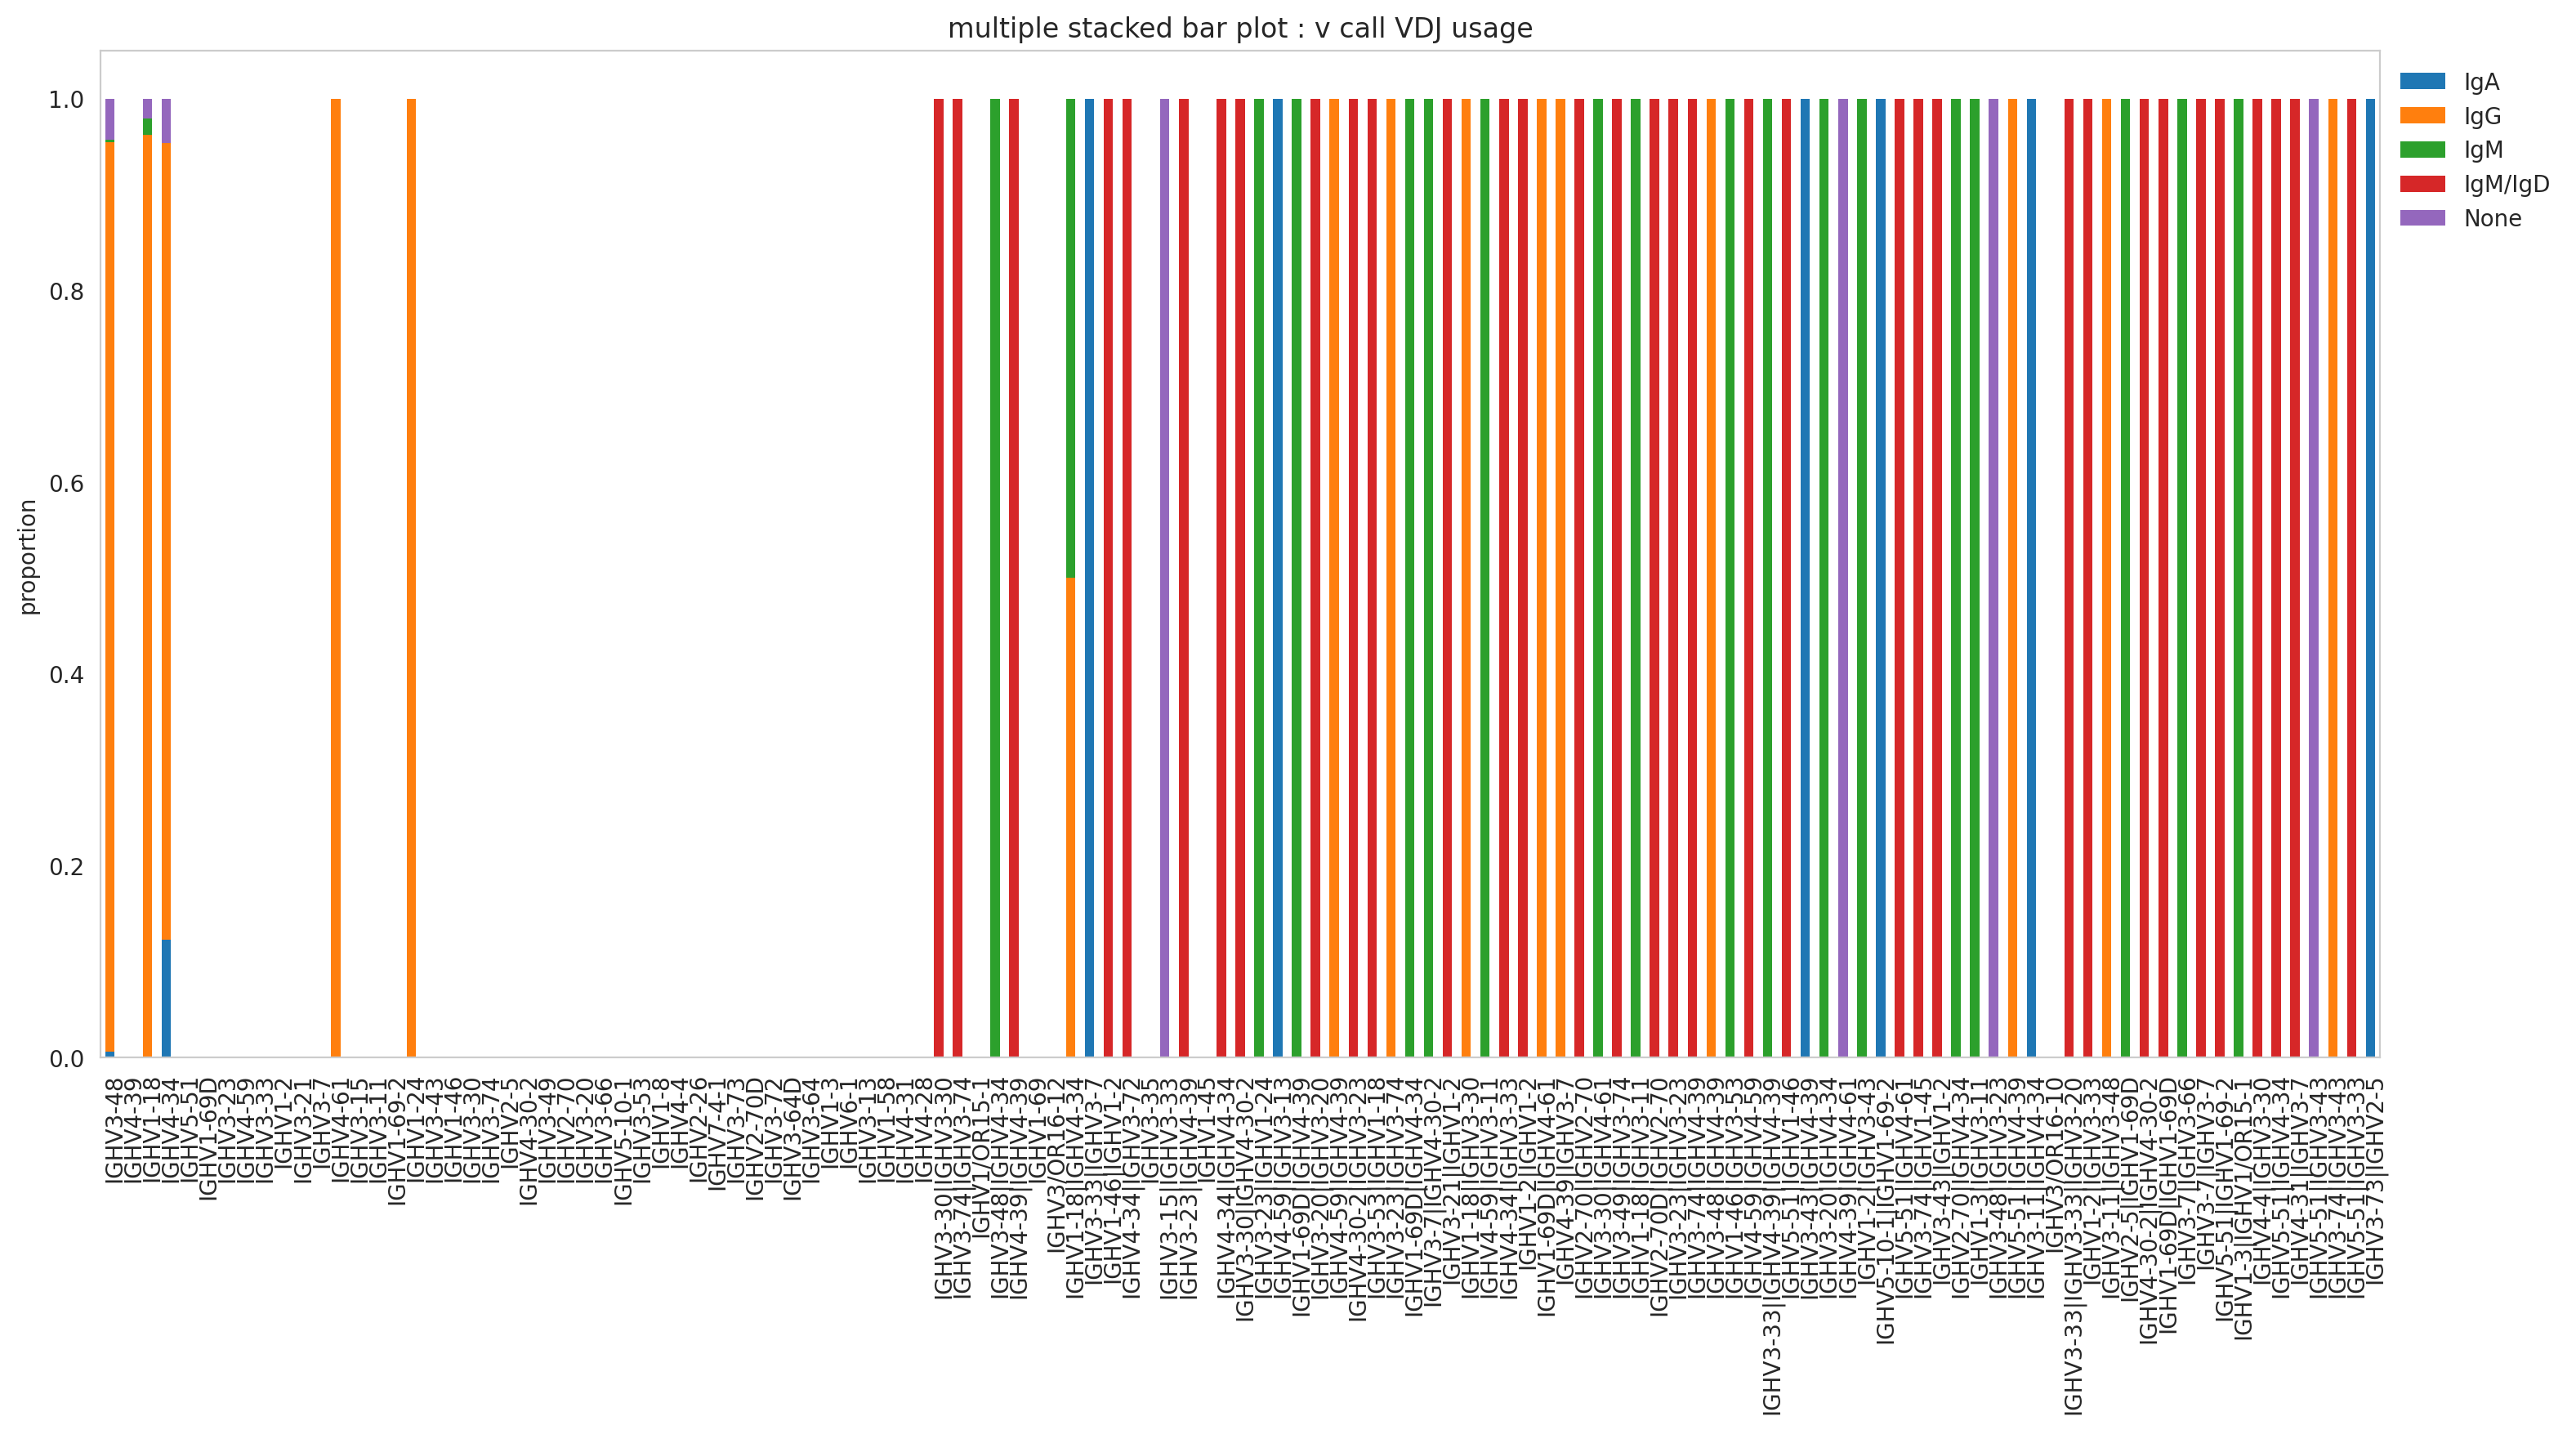

In [16]:
_ = (
    ddl.pl.stackedbarplot(
        vdjx[vdjx.metadata.isotype_status != "Multi"],
        clone_key="changeo_clone_id",
        color="v_call_VDJ",
        groupby="isotype_status",
        min_clone_size=50,
        xtick_rotation=90,
        figsize=(18, 8),
        normalize=True,
    ),
)

_ = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)

The plot above showed that IgG mostly used the V segments **IGHV3-48** and **IGHV1-18**. It could be due to IgG being the isotype most expanded. Therefore, it masked the gene segment usage from the rest of the isotypes.

This fact was supported by the plot showed below. The abundance of isotypes in the biggest clonotypes (size > 50 cells) is represented by IgG almost entirely. However, this plot provided additional evidence about the immune response triggered by the samples.

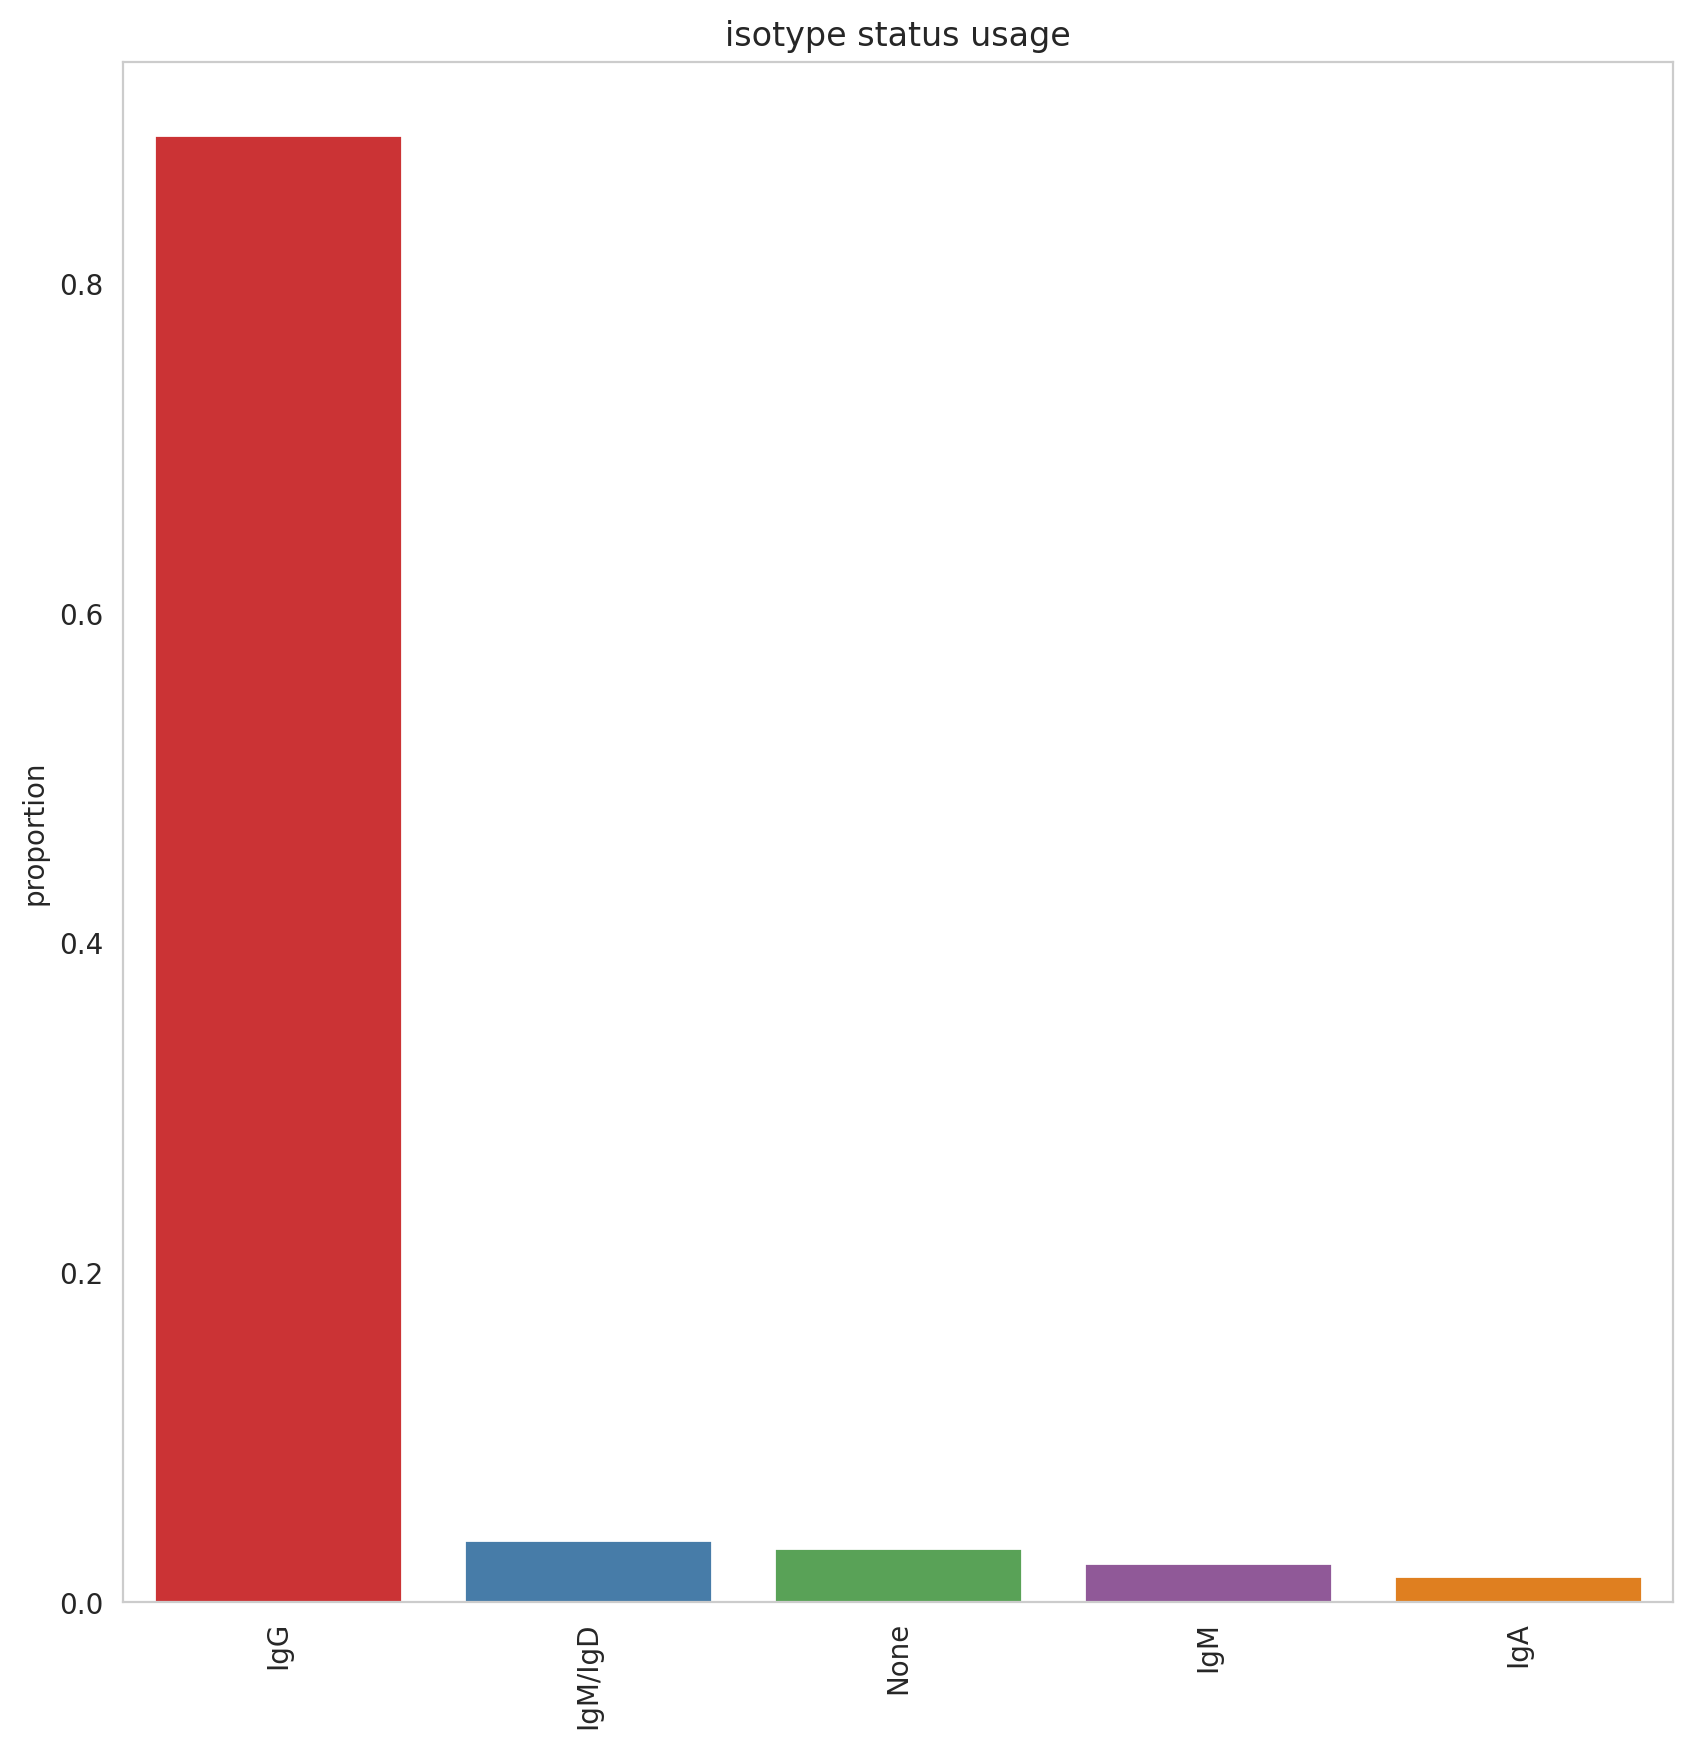

In [17]:
_ = ddl.pl.barplot(
    vdjx[vdjx.metadata.isotype_status != "Multi"],
    clone_key="changeo_clone_id",
    color="isotype_status",
    min_clone_size=50,
    figsize=[10, 10],
)

# Spectratype

We have identified key expanded clonotypes and the isotype they represented. In addition, we can explore spectratype to observe the dominance in terms of sequence length. As well as in the previous analysis, we discarded the multi-chain cells, and we conserved those clonotypes whose sizes were higher than 50 cells to keep the analysis consistency.

The plot below shown an interesting behaviour, despite the clear spectratype dominance reflected in our previous TCR analysis. Here, two sequence lengths raised, the first and the most dominant conformed by sequences of 23 aminoacids, and the second one composed by 15 aminoacids.

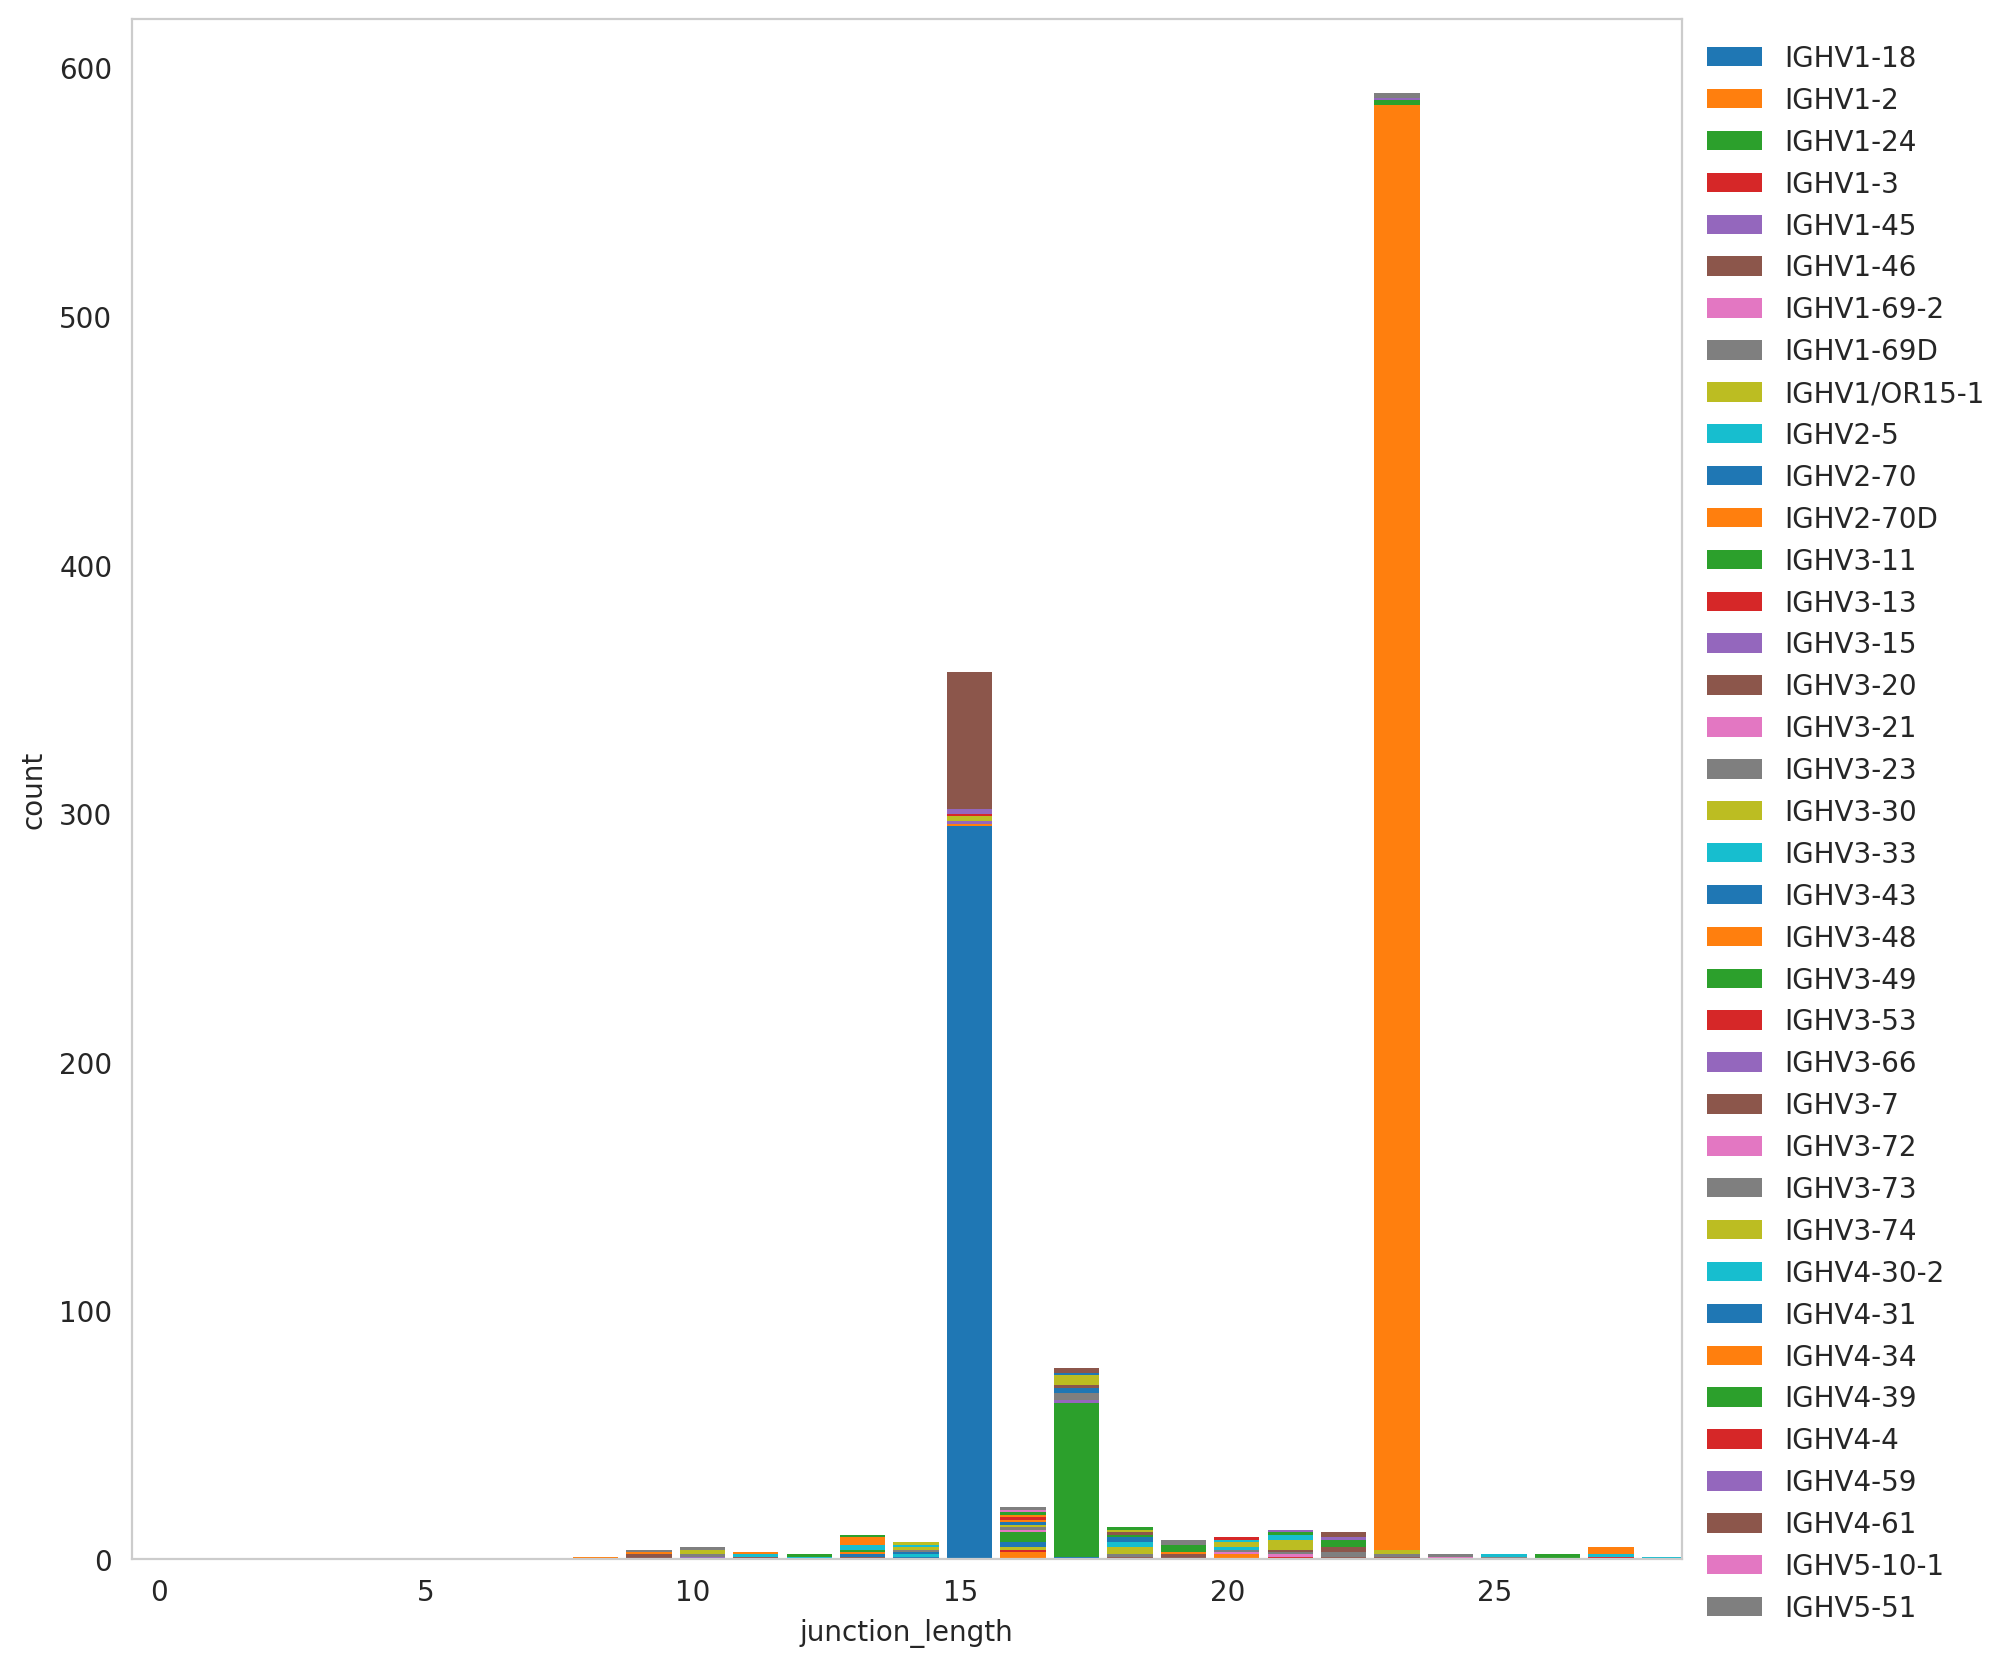

In [18]:
_ = ddl.pl.spectratype(
    vdjx[
        (vdjx.metadata.isotype_status != "Multi")
        & (vdjx.metadata.changeo_clone_id_size > 50.0)
    ],
    color="junction_length",
    groupby="v_call",
    locus="IGH",
    figsize=(10, 10),
)
_ = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", frameon=False)

# Motif sequence analysis

The results from spectratype gave us a hint about which sequences to compare, looking for a possible amino acid motif. In this case, we analyzed the V segment for **IGHV3-48** and **IGHV1-18** with a sequence length of 15 and 23 amino acids. Let us start with the first comparison (length = 15).

In [19]:
ddl.tl.transfer(adata, vdjx, clone_key="changeo_clone_id")

In [20]:
motif = compute_motif(
    adata[
        (adata.obs["IR_VDJ_1_v_call"].isin(["IGHV3-48", "IGHV1-18"]))
        & (adata.obs["junction_aa_VDJ"].str.len() == 15),
        :,
    ]
    .obs["junction_aa_VDJ"]
    .to_list()
)

In [21]:
_ = svg_logo(
    motif, "../_static/images/air_repertoire/bcr_logo_motif.svg", color_scheme="taylor"
)

We can observe a clear dominance of the aminoacid proportion in almost all the positions, excepting for a couple of them we some additional aminoacids share the sequence motif landscape. However, the sequence composition for those V segments of interest with length 15 is quite stable.

![](../_static/images/air_repertoire/bcr_logo_motif.svg)

On the other hand, we analyzed the same V gene segments for the V(D)J chain but with a sequence length of 23 aminoacids.

In [22]:
motif = compute_motif(
    adata[
        (adata.obs["IR_VDJ_1_v_call"].isin(["IGHV3-48", "IGHV1-18"]))
        & (adata.obs["junction_aa_VDJ"].str.len() == 23),
        :,
    ]
    .obs["junction_aa_VDJ"]
    .to_list()
)

In [23]:
_ = svg_logo(
    motif, "../_static/images/air_repertoire/bcr2_logo_motif.svg", color_scheme="taylor"
)


![](../_static/images/air_repertoire/bcr2_logo_motif.svg)

## References

```{bibliography}
:filter: docname in docnames
```